<a href="https://colab.research.google.com/github/Qiustander/Simple_MCMC_tasks/blob/main/MCMC_For_Multivariate_Normal_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>.
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
In summary, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [1]:
#@title Imports and Global Variables  { display-mode: "form" }
"""Import necessary packages and set global variables
"""
!pip3 install -q pandas_datareader
!pip3 install -q wget
!pip3 install statsmodels
from __future__ import absolute_import, division, print_function

import numpy as np
import os
import statsmodels.api as sm
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'seaborn' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability.python.internal import prefer_static as ps


def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def credible_interval(posterior_dist, alpha=0.05):
    """
    Compute the credible interval for a set of samples.

    Parameters:
    - posterior_dist: array-like, the set of samples
    - alpha: float, desired significance level (e.g., 0.05 for 95% credible interval)

    Returns:
    - tuple containing the lower and upper bounds of the credible interval
    """
    sorted_samples = np.sort(posterior_dist)
    lower_bound = np.percentile(sorted_samples, 100 * alpha / 2)
    upper_bound = np.percentile(sorted_samples, 100 * (1 - alpha / 2))

    return (lower_bound, upper_bound)


from tensorflow_probability.python.mcmc import RandomWalkMetropolis
from tensorflow_probability.python.mcmc import HamiltonianMonteCarlo
from tensorflow_probability.python.mcmc import sample_chain

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')


  Preparing metadata (setup.py) ... done


<ipython-input-1-07e25d13c328>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)


TnesorFlow version: 2.12.0
TnesorFlow Probability version: 0.20.1


# MCMC For Fitting 3D Normal Distribution

We have $N$ points observed data: $p(\mathbf{x_i}|\mathbf{\mu}, \Sigma)\in \mathbb{R}^N \sim \mathcal{N}(\mathbf{\mu}, \Sigma), i = 1, \dots, N$, where $\mu \in \mathbb{R}^N$ or $σ^2 \in \mathbb{R}_+^{N \times N}$ maybe unknown. $\mathbf{x_i}$ denotes $n$-th data sample.

Problem:
1. estimate $p(\mu|\mathbf{x},\Sigma) ∝ \pi(\mu)l(\mathbf{x}|\mu, \Sigma)$
2. estimate $p(\Sigma|\mathbf{x},\mu) ∝ \pi(\Sigma)l(\mathbf{x}|\mu, \Sigma)$
3. estimate $p(\Sigma, \mu|\mathbf{x}) ∝ \pi(\mu)\pi(\Sigma)l(\mathbf{x}|\mu, \Sigma)$,

where $\pi(\cdot)$ is the prior distribution and $l(\cdot)$ denotes the data likelihood.

We generate sample data from a multivariate normal distribution using TensorFlow Probability Distributions.

In [2]:
# Set seed
seed = 50
tf.random.set_seed(seed=seed)
# Number of samples.
n = 100
signal_dim = 3
# True parameters
true_mean = tf.constant([1.2, 0.5, 1.8])
true_std = tf.constant([[0.8, 0, 0], [0.6, 0.2, 0], [0.1, 0.4, 1.5]]) # define a lower triangular cholesky part

# Define Normal distribution with the true parameters, event_shape:1,
normal_true = tfd.MultivariateNormalTriL(loc=true_mean,
                                          scale_tril=true_std)
# Generate samples.
observations = normal_true.sample(sample_shape=n)
sample_mean = tf.reduce_mean(observations, axis=0)
sample_std = tfp.stats.cholesky_covariance(observations, sample_axis=0)

print(f'sample mean: {sample_mean}')
print(f'sample std: {sample_std}')

PRIOR_MEAN = tf.constant([1.0, 1.0, 1.0])
PRIOR_STD = tf.constant([[1.0, 0, 0], [1.0, 1.0, 0], [1.0, 1.0, 1.0]])
PRIOR_DF = 3
PRIOR_SCALE= tf.linalg.diag(tf.random.uniform([signal_dim]))/PRIOR_DF


sample mean: [1.1973401 0.4968525 1.9548292]
sample std: [[ 0.8203042   0.          0.        ]
 [ 0.6052938   0.20655912  0.        ]
 [-0.03693856  0.5427485   1.5207639 ]]


## Estimation of unknown $\mathbf{\mu}$, given $\Sigma$

First of all, define a prior distribution which represents the belief for $\mathbf{\mu}$.

Define $\pi(\mu) \sim \mathcal{N}(\mathbf{\mu}_0, \Sigma_0)$ which is a multivariate normal distribution.

Data likelihood function $l(\mathbf{x}|\mathbf{\mu}, \Sigma) = \prod_{i=1} \mathcal{N}(\mathbf{x}_i| \mu, \Sigma)$.

Therefore, the posterior distribution $p(\mathbf{\mu}|\Sigma, \mathbf{x})$ is still a multivariate normal distribution, it is actually the conjugate prior to the prior distribution. In practice, we apply $\log$  likelihood and prior distribution such that we just need  addition instead of product which may result in underflow floating point precision.

In [3]:
num_mcmc_samples = 6000
num_burn_in_steps = int(num_mcmc_samples//3)
# The number of chains is determined by the shape of the initial values.
# Here we'll generate N_CHAINS chains, so we'll need a tensor of N_CHAINS initial values.
N_CHAINS = 8

# Replicate the observations for each chain
replicate_observations = tf.tile(tf.expand_dims(observations, axis=1), multiples=[1, N_CHAINS, 1])

In [4]:
init_state = tf.random.normal([N_CHAINS, signal_dim])

"""
define prior distribution
"""
def prior_dist(parameter):
  return tfd.MultivariateNormalTriL(loc=PRIOR_MEAN,
                                  scale_tril=PRIOR_STD).log_prob(parameter)

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(parameter):
        return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=parameter,
                                                        scale_tril=sample_std).log_prob(observations), axis=0) \
                                                        + prior_dist(parameter)

    return _compute_posterior

"""
Sampling
"""

@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=5,
                                        kernel=mh_kernel,
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.02,
                                    num_leapfrog_steps=2)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=hmc_kernel,
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()



/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


#### Analytical Posterior Distribution

Assume that given $\Sigma$, define the prior of the $\mu$ as the $\pi(\mu) \sim \mathcal{N}(\mu_0, \Sigma_0)$, the posterior distribution of $\mu$ is also a Normal distribution that has the analytical form:
$$
\mathcal{N}\left( \left(\boldsymbol{\Sigma}_0^{-1}+n \boldsymbol{\Sigma}^{-1}\right)^{-1}\left(\boldsymbol{\Sigma}_0^{-1} \boldsymbol{\mu}_0+n \boldsymbol{\Sigma}^{-1} \overline{\mathbf{x}}\right), \left(\boldsymbol{\Sigma}_0^{-1}+n \boldsymbol{\Sigma}^{-1}\right)^{-1}\right)
$$ where $\overline{\mathbf{x}}$ is the sample mean

In [5]:
# very stupid computation for simplicity
prior_inv = tf.linalg.triangular_solve(PRIOR_STD, tf.eye(tf.shape(PRIOR_STD)[0], dtype=PRIOR_STD.dtype), lower=True)
prior_cov_inv = tf.matmul(prior_inv, prior_inv, transpose_a=True)

sample_inv = tf.linalg.triangular_solve(sample_std, tf.eye(tf.shape(sample_std)[0], dtype=sample_std.dtype), lower=True)
sample_cov_inv = tf.matmul(sample_inv, sample_inv, transpose_a=True)

coeff = tf.linalg.inv(prior_cov_inv + ps.shape(observations)[0]*sample_cov_inv)

true_posterior_mean = tf.linalg.matvec(coeff,
                                       tf.linalg.matvec(prior_cov_inv, PRIOR_MEAN)
                                       + ps.shape(observations)[0]*tf.linalg.matvec(sample_cov_inv, sample_mean))
true_posterior_std = tf.linalg.cholesky(coeff)


#quick sanity check of matrix multiplication

# PRIOR_STD = tf.constant([[np.random.uniform(), 0, 0], [np.random.uniform(), np.random.uniform(), 0], [np.random.uniform(), np.random.uniform(), np.random.uniform()]])
# a = tf.matmul(PRIOR_STD, PRIOR_STD, transpose_b=True)
# b = tf.linalg.inv(a)
# c = tf.linalg.triangular_solve(PRIOR_STD, tf.eye(tf.shape(PRIOR_STD)[0], dtype=PRIOR_STD.dtype), lower=True)
# d = tf.matmul(c, c, transpose_a=True)

### Diagnostics for MCMC sampler

Tensorflow probability provides various diagnostic tools to check the convergence of the chain.

In [6]:
r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")


accept_rate_mh = tf.math.count_nonzero(mh_results.is_accepted, axis=0)/num_mcmc_samples
accept_rate_hmc = tf.math.count_nonzero(hmc_results.is_accepted, axis=0)/num_mcmc_samples

print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")


ess_mh = tfp.mcmc.effective_sample_size(
    mh_states,
    cross_chain_dims=1,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states,
    cross_chain_dims=1,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")

R^hat for MH algorithm [1.0008504 1.0008215 1.0039197]
R^hat for HMC algorithm [1.0117089 1.0106106 1.0200245]
Acceptance rate for MH algorithm [0.14283333 0.14116667 0.14783333 0.14383333 0.13683333 0.14483333
 0.1455     0.14433333]
Acceptance rate for HMC algorithm [0.94616667 0.94216667 0.94083333 0.939      0.944      0.93916667
 0.94583333 0.943     ]


Effective sample size for MH algorithm [6923.601  7042.6636 3633.676 ]
Effective sample size for HMC algorithm [1916.1154 1937.5817  625.6388]


<ipython-input-7-bb2e7fd260d2>:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


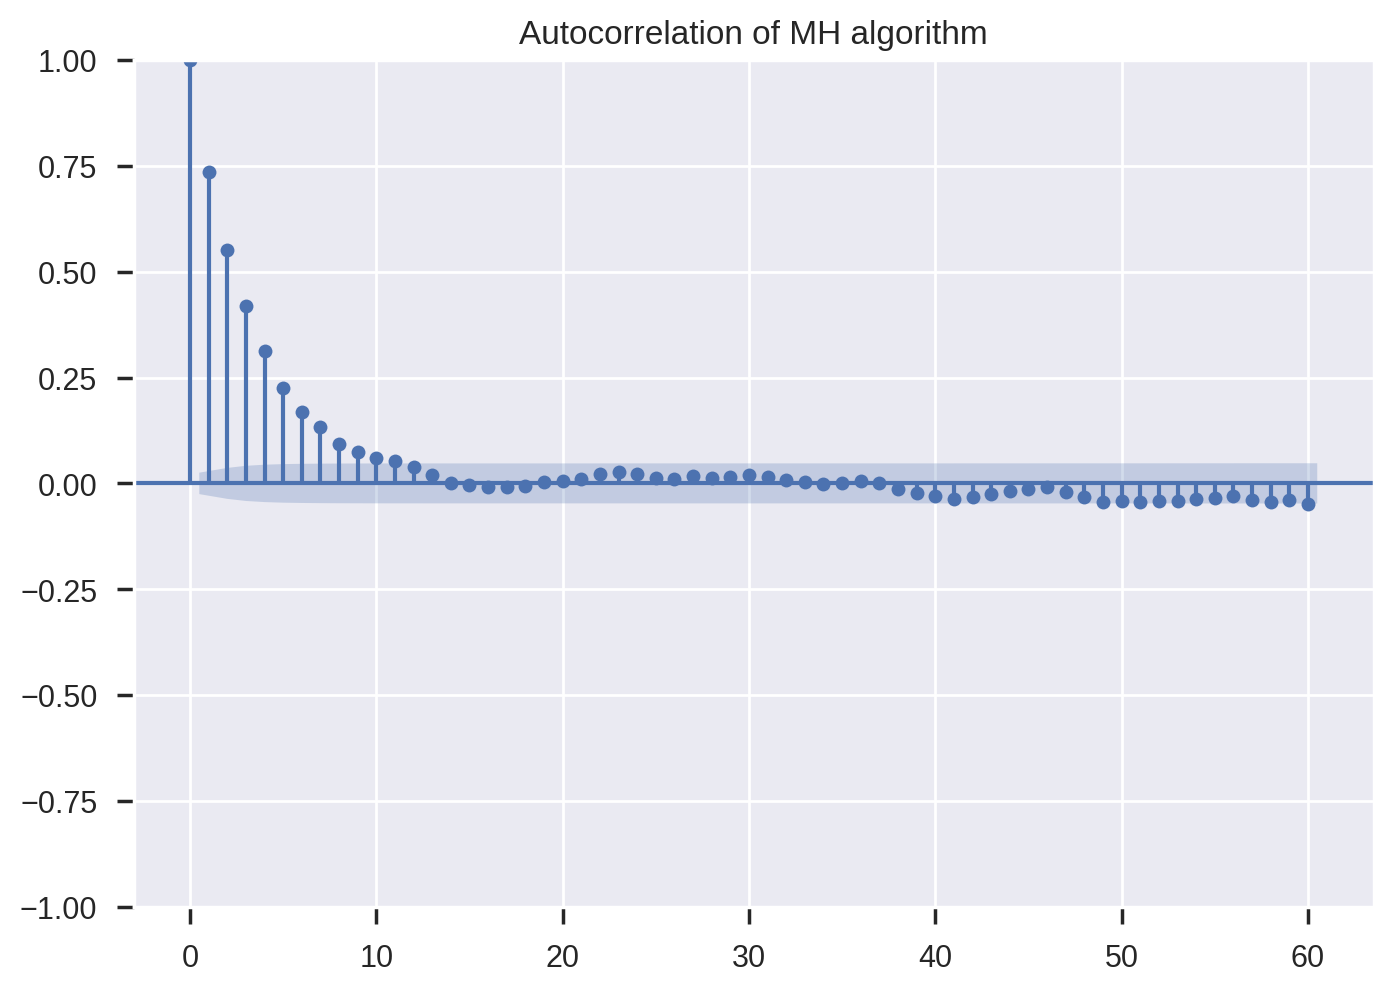

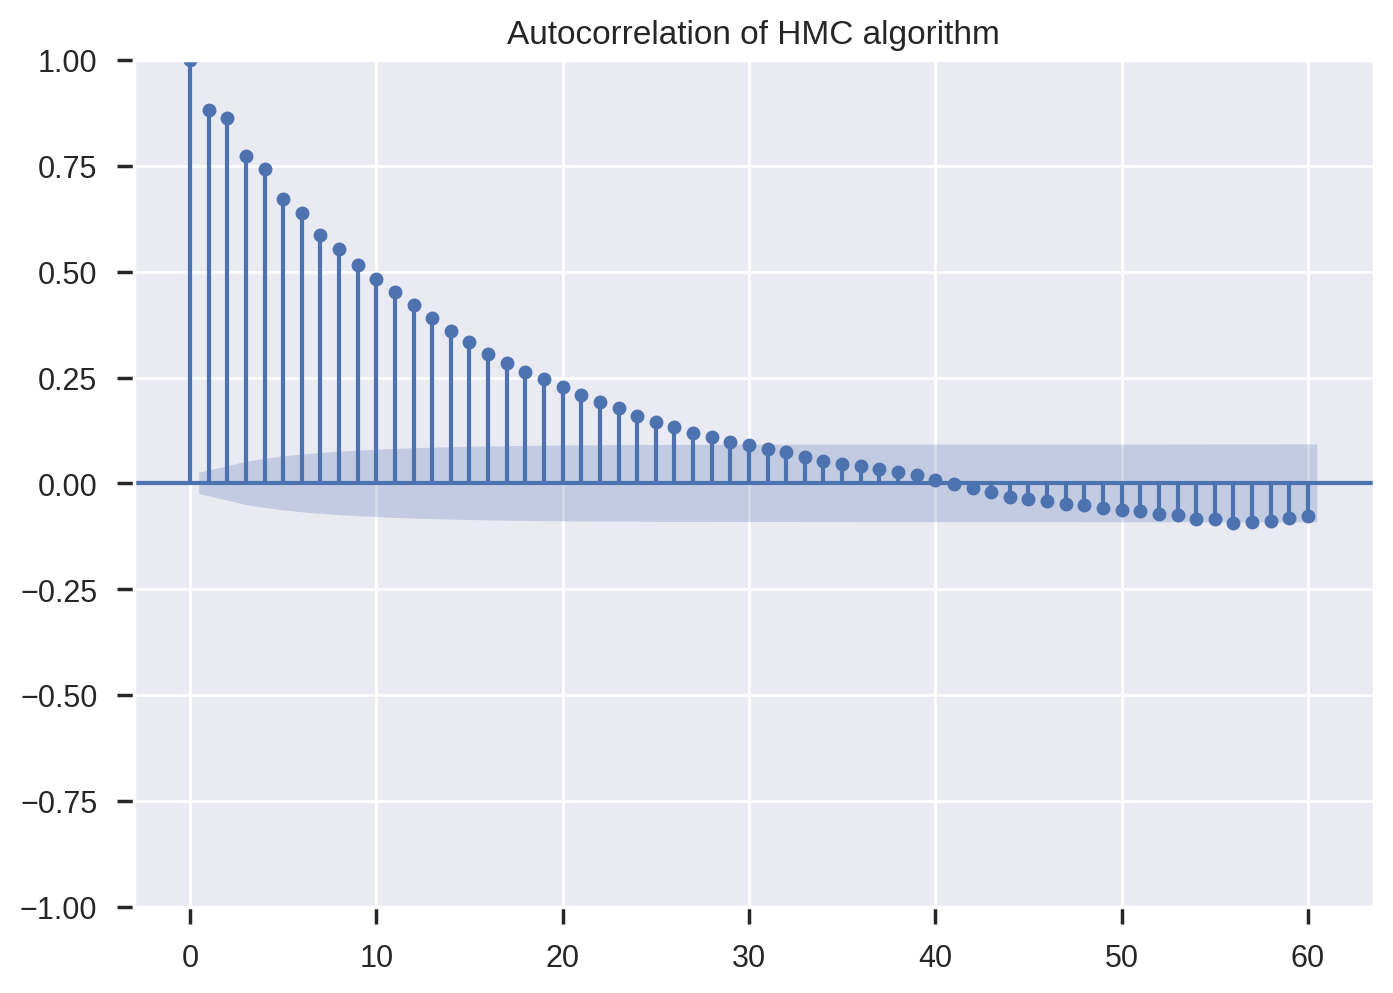

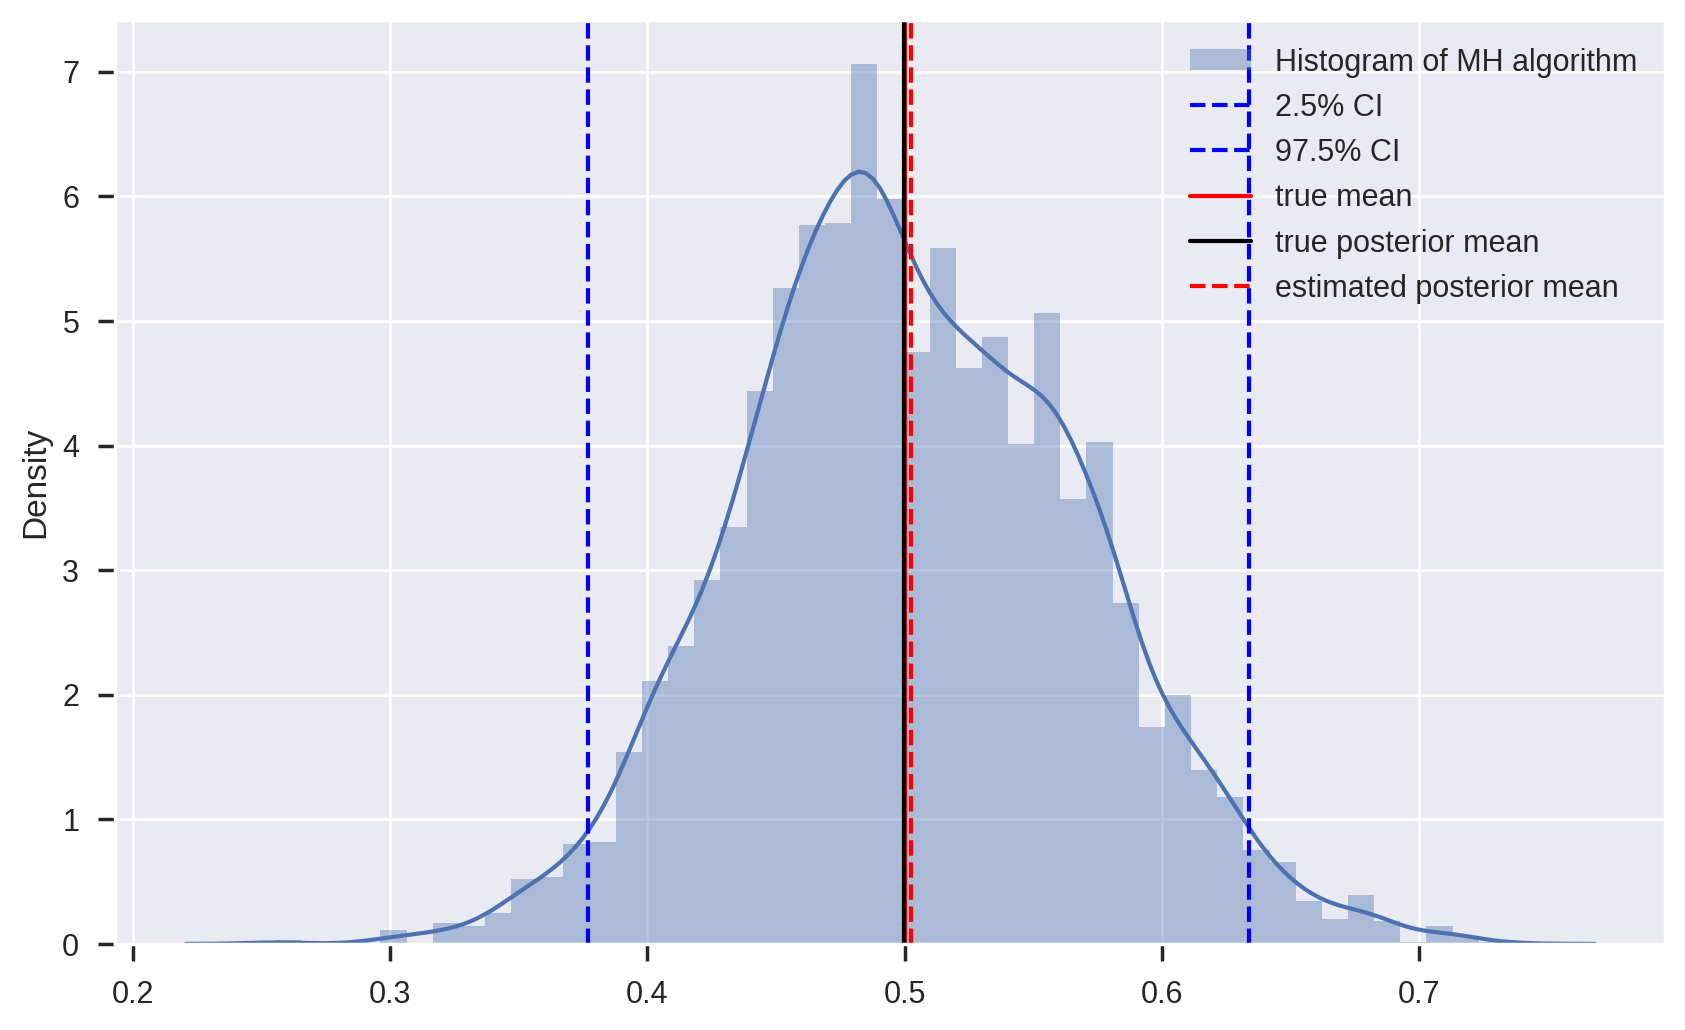

<ipython-input-7-bb2e7fd260d2>:55: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


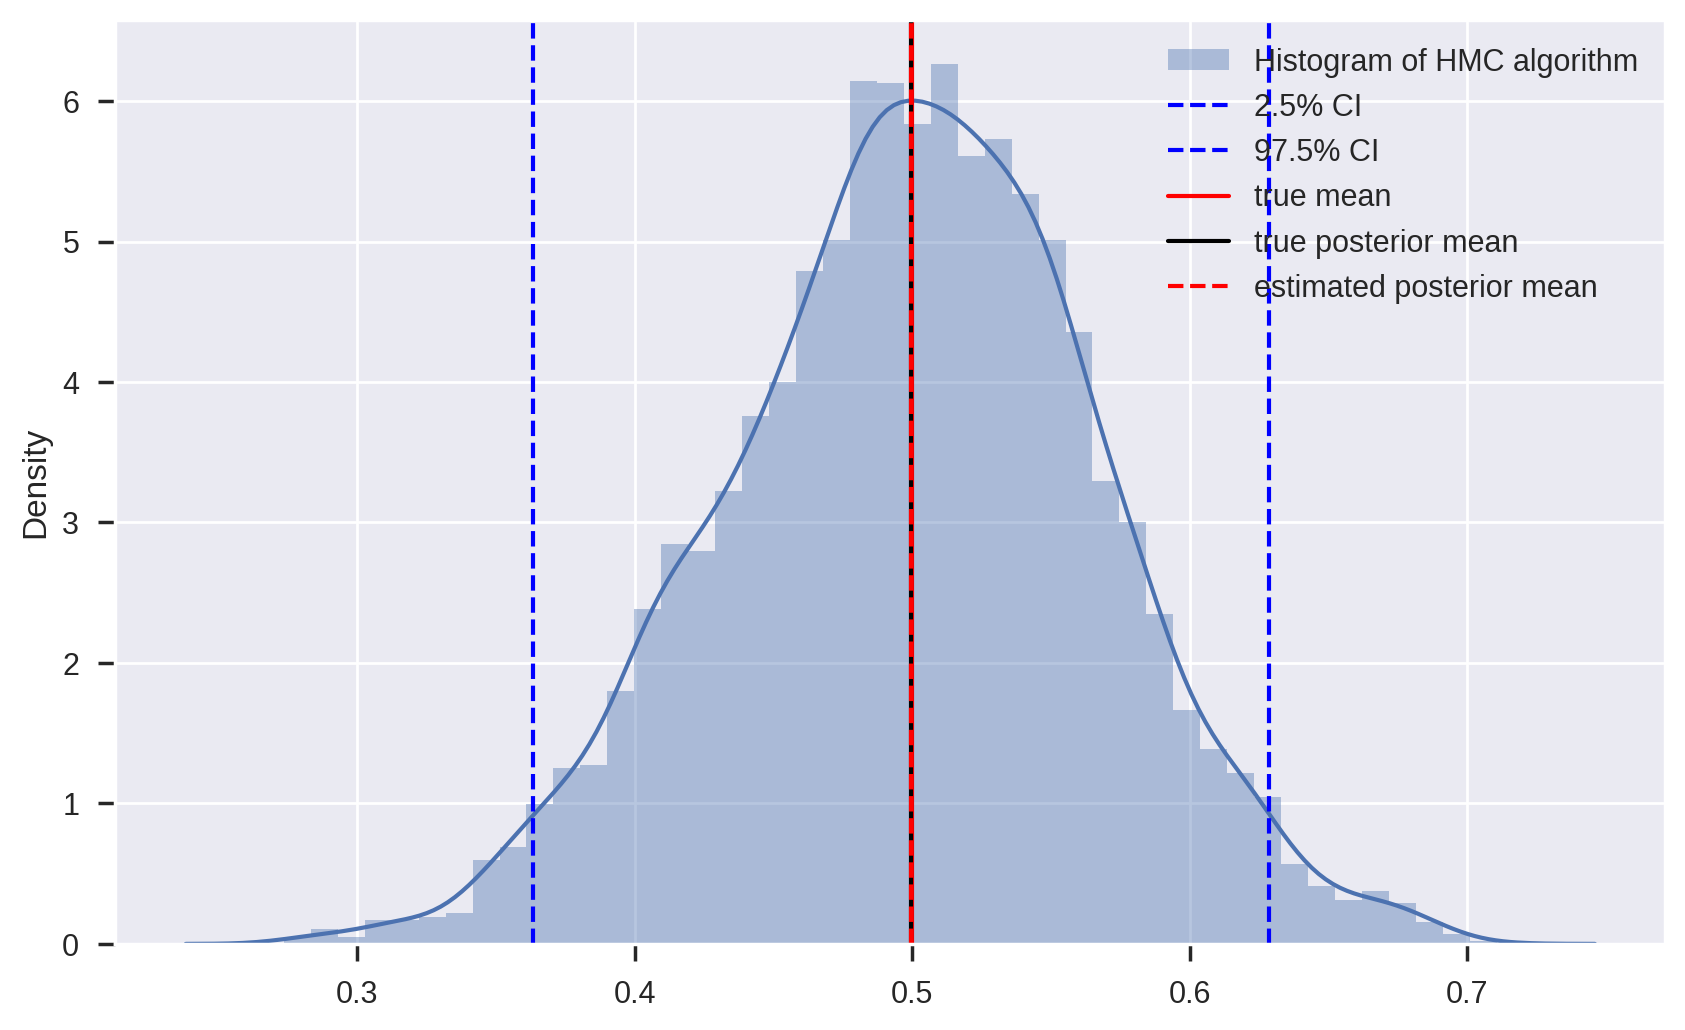

In [7]:
# use the first chain for plotting auto-correlation,
inspect_mean = 1

sm.graphics.tsa.plot_acf(mh_states[:, 0, inspect_mean],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states[:, 0, inspect_mean],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)


# plot the fist chain

mh_dist = mh_states[:, 0, inspect_mean]
hmc_dist = hmc_states[:, 0, inspect_mean]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     mh_dist,
#     np.abs(np.random.randn(mh_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean[inspect_mean], color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean[inspect_mean], color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     hmc_dist,
#     np.abs(np.random.randn(hmc_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean[inspect_mean], color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_mean[inspect_mean], color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()

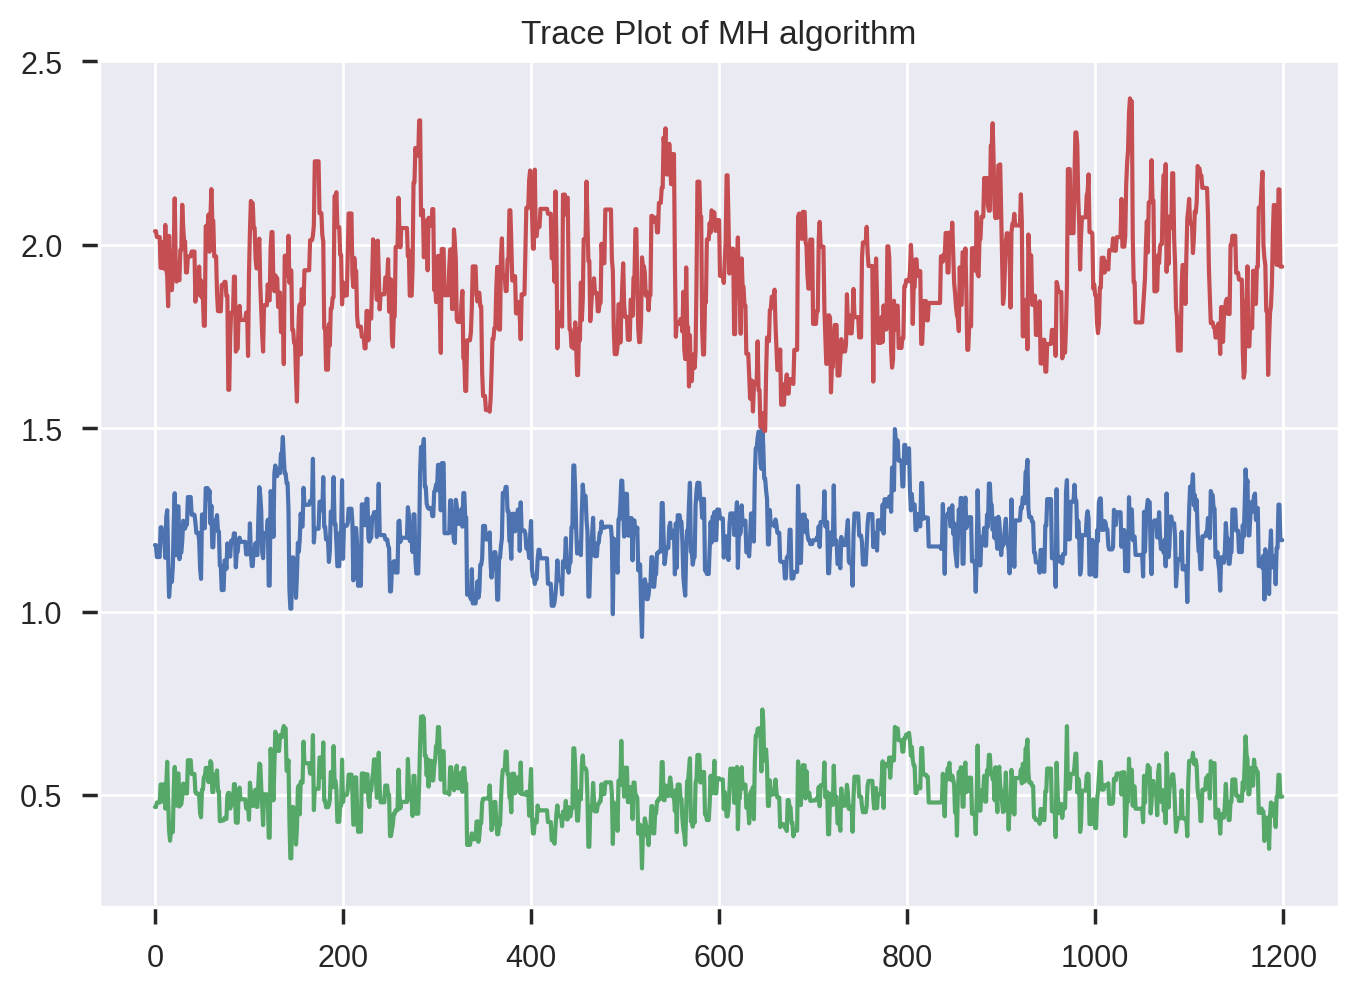

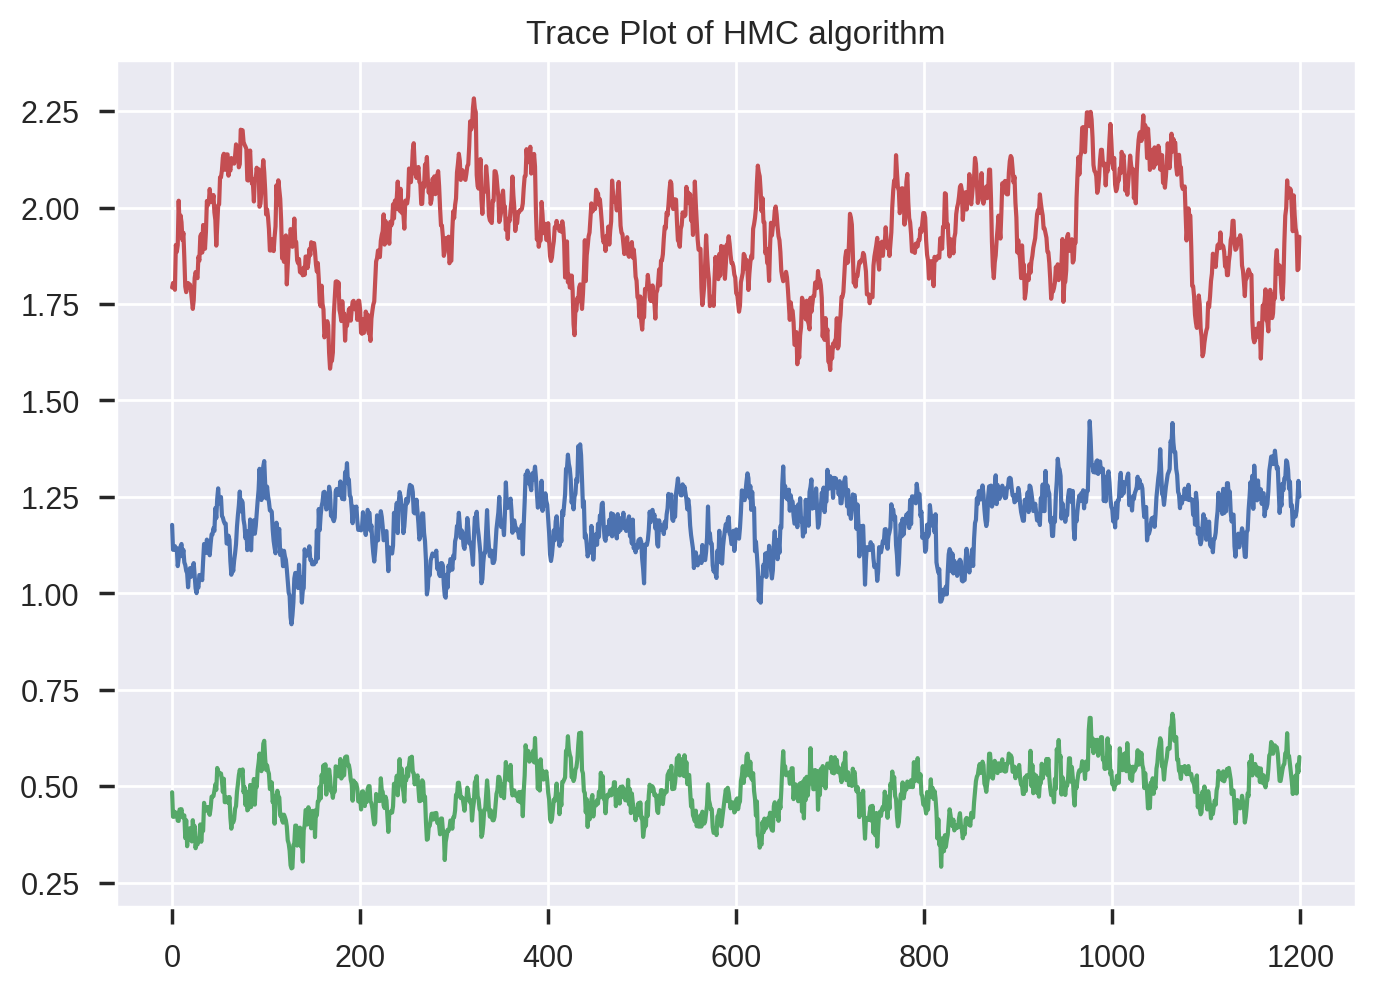

In [8]:
# trace the fist chain
plt.plot(tf.squeeze(mh_states[-num_mcmc_samples//5:, 0]))
plt.title("Trace Plot of MH algorithm")
plt.show()

plt.plot(tf.squeeze(hmc_states[-num_mcmc_samples//5:, 0]))
plt.title("Trace Plot of HMC algorithm")
plt.show()

## Estimation of unknown $\Sigma$, given $\mathbf{\mu}$

First of all, define a prior distribution which represents the belief for $\Sigma$.

Define $\pi(\Sigma) \sim \mathcal{IW}(\mathbf{\nu}_0, \Psi_0)$ which is a Inverse-Wishart distribution. However, TFP does not have Inverse-Wishart distribution. We can transfer the problem to estimate the precsion matrix $\pi(\Lambda) \sim \mathcal{W}(\mathbf{\nu}_0, V_0)$ which is the inverse matrix of the covariance matrix. The prior distribution is the Wishart distribution.

Data likelihood function $l(\mathbf{x}|\mathbf{\mu}, \Lambda) = \prod_{i=1} \mathcal{N}(\mathbf{x}_i| \mu, \Lambda)$.

Therefore, the posterior distribution $p(\Lambda|\mathbf{\mu}, \mathbf{x})$ is still a Wishart distribution, it is actually the conjugate prior to the prior distribution. In practice, we apply $\log$  likelihood and prior distribution such that we just need  addition instead of product which may result in underflow floating point precision.

#### Sampling In Unconstrainted Space

Similar with the univariate case, we would apply *TransformedTransitionKernel* to sample in the unconstrainted space.

In multivariate case, the transform woule be a bit complicated. We need 3 steps to transform the unconstrainted parameters back to the constrainted precision matrix - lower triangular, and the diagonal elements must be positive.

1. Transform the vector to the lower triangular matrix. In the unconstrainted space, we can sample the lower triangular parts of the precision matrix which is a vector with $\frac{N(N+1)}{2}$ elements.

2. Exponentiate the diagonal elements to ensure the positive values

3. Compute $g(X) = XX^T$ where $X$ is lower-triangular, positive-diagonal matrix.



In [9]:
init_state = tf.linalg.diag(tf.random.uniform([N_CHAINS, signal_dim]))

"""
define prior distribution
"""
def prior_dist(parameter):

  return tfd.WishartTriL(
      df=PRIOR_DF,
      scale_tril=tf.linalg.cholesky(PRIOR_SCALE)).log_prob(parameter)

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(parameter):
      precisions_cholesky = tf.linalg.cholesky(parameter)
      covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(signal_dim, batch_shape=[N_CHAINS]))
      return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=sample_mean,
                                                        scale_tril=tf.linalg.cholesky(covariances)).log_prob(observations), axis=0) \
                                                        + prior_dist(parameter)

    return _compute_posterior

"""
Sampling
"""
transformed_bijector = tfb.Chain([
    # step 3: take the product of Cholesky factors
    tfb.CholeskyOuterProduct(),
    # step 2: exponentiate the diagonals
    tfb.TransformDiagonal(tfb.Exp()),
    # step 1: map a vector to a lower triangular matrix
    tfb.FillTriangular(),
])

@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start, we use sigma as matrix here
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=4,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(mh_kernel,
                                                                                    bijector=transformed_bijector),
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.03,
                                    num_leapfrog_steps=3)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=init_state, #constant start
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(hmc_kernel,
                                                                                    bijector=transformed_bijector),
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()



/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


#### Analytical Posterior Distribution

Assume that given $\mu$, define the prior of the $\Lambda$ as the $\pi(\Lambda) \sim \mathcal{W}(\mathbf{\nu}_0, V_0)$, the posterior distribution of $\Lambda$ is also a Wishart distribution that has the analytical form:
$\mathcal{W}\left(n+\nu_0,\left(\mathbf{V}_0^{-1}+\sum_{i=1}^n\left(\mathbf{x}_{\mathbf{i}}-\boldsymbol{\mu}\right)\left(\mathbf{x}_{\mathbf{i}}-\boldsymbol{\mu}\right)^T\right)^{-1}\right)$

In [10]:
#@title Diagonics  { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

accept_rate_mh = tf.math.count_nonzero(mh_results.inner_results.is_accepted, axis=0)/num_mcmc_samples
accept_rate_hmc = tf.math.count_nonzero(hmc_results.inner_results.is_accepted, axis=0)/num_mcmc_samples

print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")

ess_mh = tfp.mcmc.effective_sample_size(
    mh_states,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")



R^hat for MH algorithm [[1.0028856 1.0042864 1.0006844]
 [1.0042864 1.0033917 1.0005014]
 [1.0006844 1.0005014 1.0015527]]
R^hat for HMC algorithm [[1.0039177 1.0071361 1.0002693]
 [1.0071361 1.0069802 1.000495 ]
 [1.0002693 1.000495  1.0000973]]
Acceptance rate for MH algorithm [0.12416667 0.11933333 0.1205     0.12116667 0.12183333 0.11716667
 0.11666667 0.12183333]
Acceptance rate for HMC algorithm [0.9435     0.9475     0.946      0.94866667 0.942      0.947
 0.9465     0.94716667]


Effective sample size for MH algorithm [[[ 415.5818   235.89348 1189.2194 ]
  [ 235.89348  194.70784 1163.6246 ]
  [1189.2194  1163.6246  1264.1422 ]]

 [[ 335.9241   218.98967  833.004  ]
  [ 218.98967  204.48587 1080.7698 ]
  [ 833.004   1080.7698  1012.1937 ]]

 [[ 262.88574  158.40489  935.1467 ]
  [ 158.40489  176.3109  1025.332  ]
  [ 935.1467  1025.332   1019.35754]]

 [[ 349.67926  227.20326 1066.214  ]
  [ 227.20326  245.48445 1259.2394 ]
  [1066.214   1259.2394  1115.815  ]]

 [[ 345.76184  225.2125   846.3997 ]
  [ 225.2125   239.7701   870.28186]
  [ 846.3997   870.28186 1076.2137 ]]

 [[ 385.88937  235.95587  931.0295 ]
  [ 235.95587  240.43164  908.47046]
  [ 931.0295   908.47046  783.1162 ]]

 [[ 329.23578  221.48734 1325.6083 ]
  [ 221.48734  232.70694 1410.4113 ]
  [1325.6083  1410.4113  1098.7129 ]]

 [[ 361.35086  232.38693  861.27026]
  [ 232.38693  248.44707  783.1943 ]
  [ 861.27026  783.1943  1112.855  ]]]
Effective sample size for HMC algorithm [[[ 423.3928   25

In [11]:
posterior_a = int(PRIOR_DF + ps.shape(observations)[0])
posterior_b = tf.linalg.inv(tf.linalg.inv(PRIOR_SCALE) + tf.matmul(observations - sample_mean, observations - sample_mean, transpose_a=True))
poster_dist  = tfd.WishartTriL(
      df=posterior_a,
      scale_tril=tf.linalg.cholesky(posterior_b))
true_posterior_mean = poster_dist.mean()
true_posterior_std = poster_dist.stddev()

precisions_cholesky = tf.linalg.cholesky(true_posterior_mean)
covariances = tf.linalg.cholesky_solve(
precisions_cholesky, tf.linalg.eye(signal_dim))
true_posterior_std = tf.linalg.cholesky(covariances)
mh_states = tf.linalg.cholesky(tf.linalg.inv(mh_states))
hmc_states = tf.linalg.cholesky(tf.linalg.inv(hmc_states))

<ipython-input-12-ecef1eed1816>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


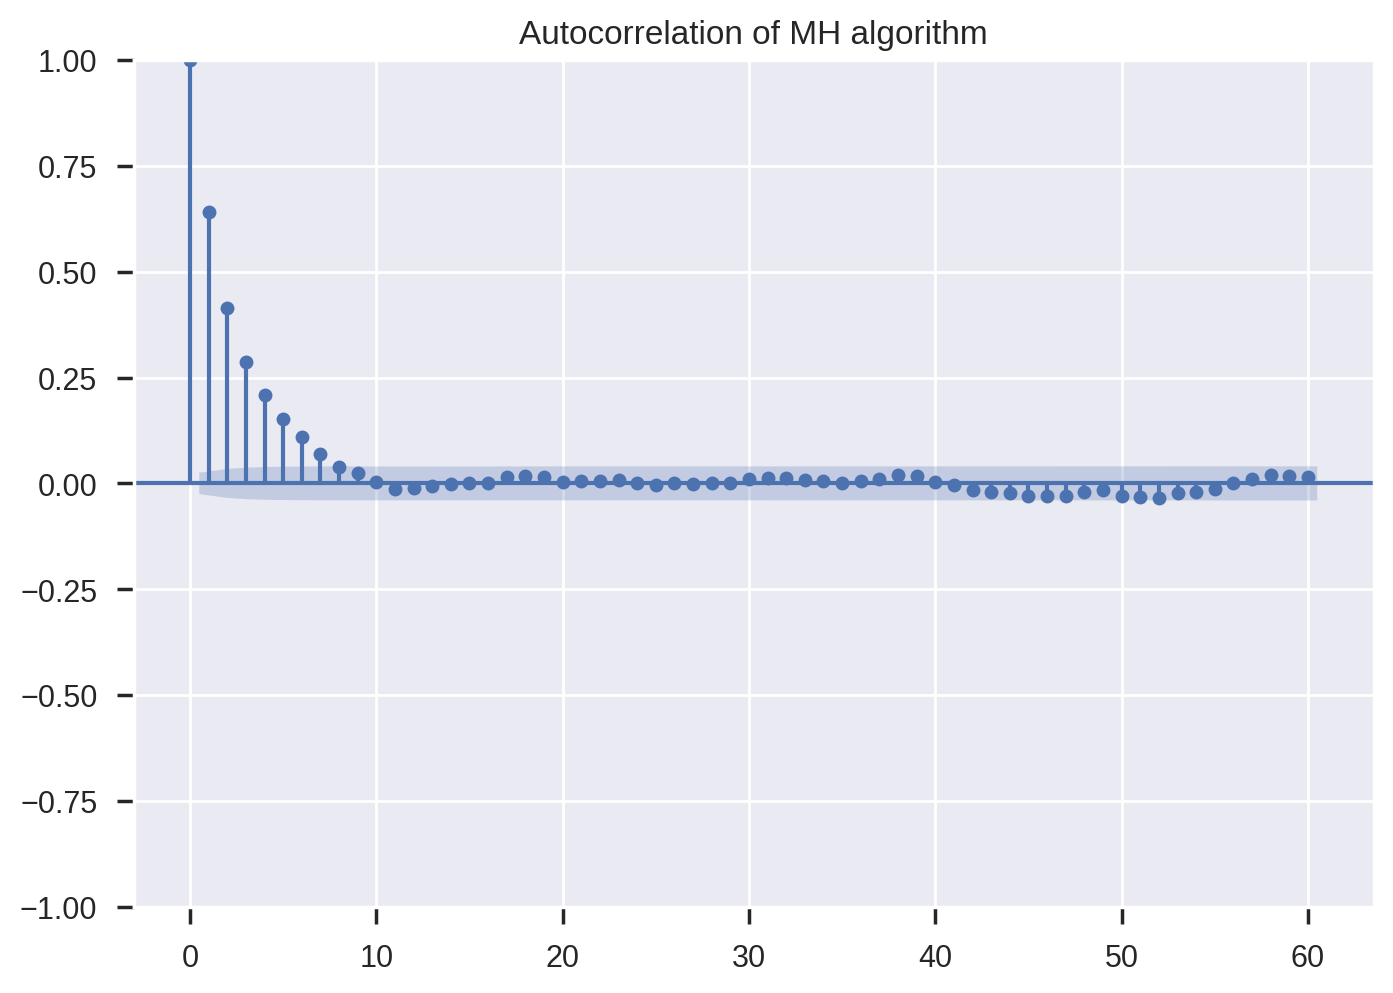

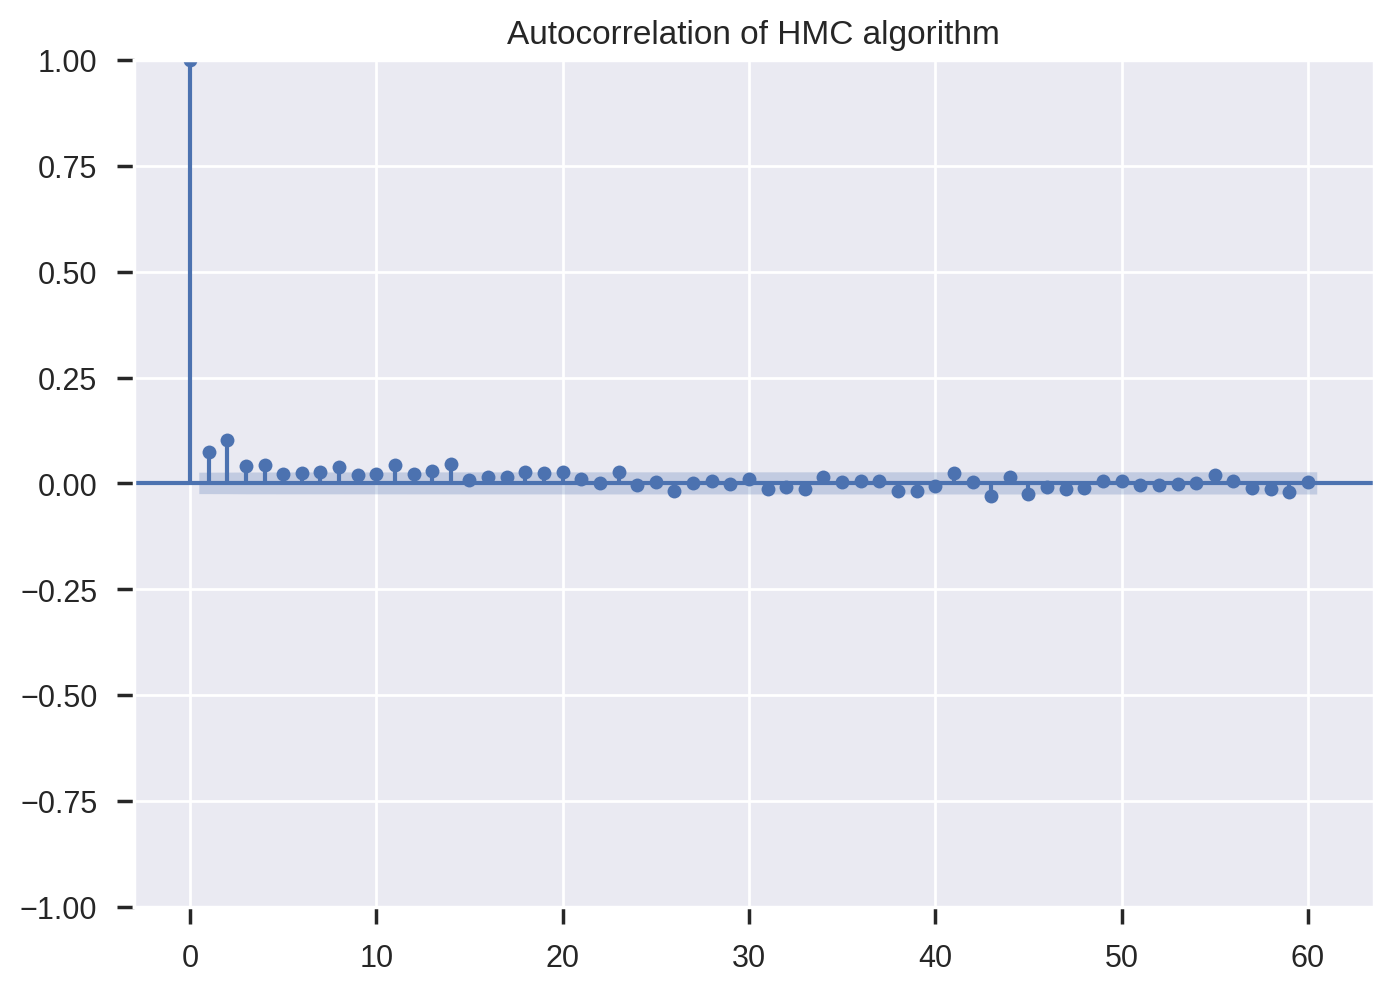

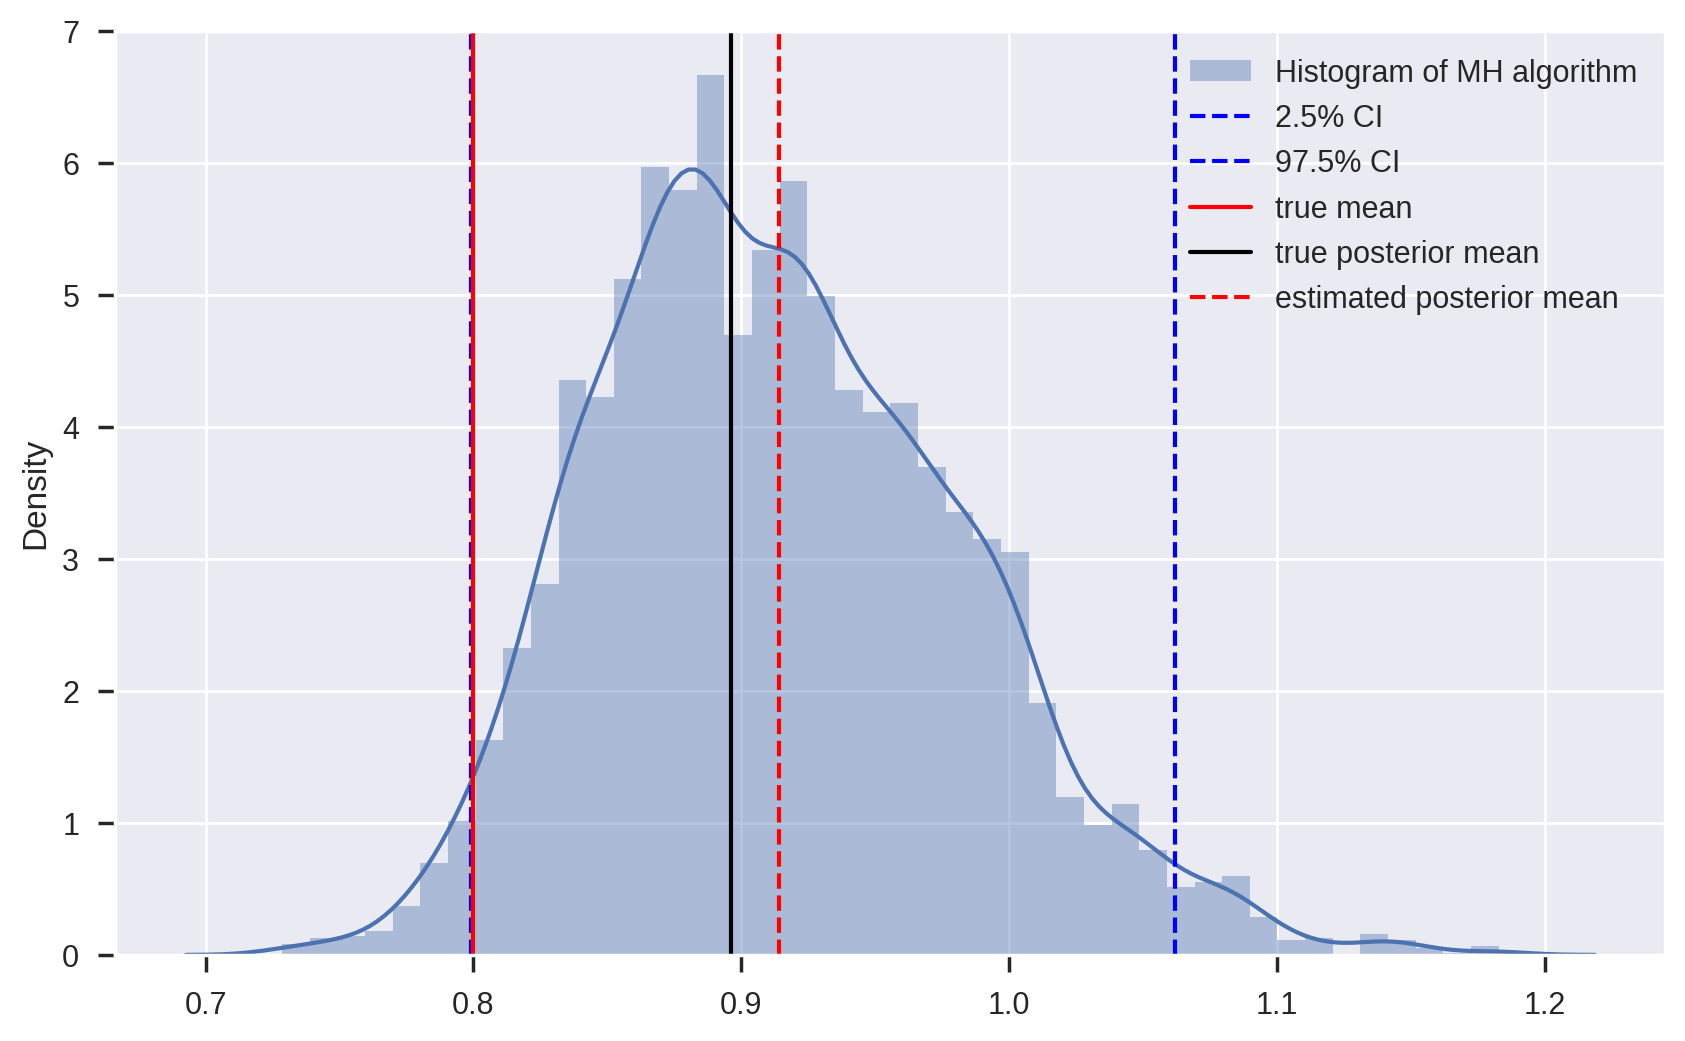

<ipython-input-12-ecef1eed1816>:57: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


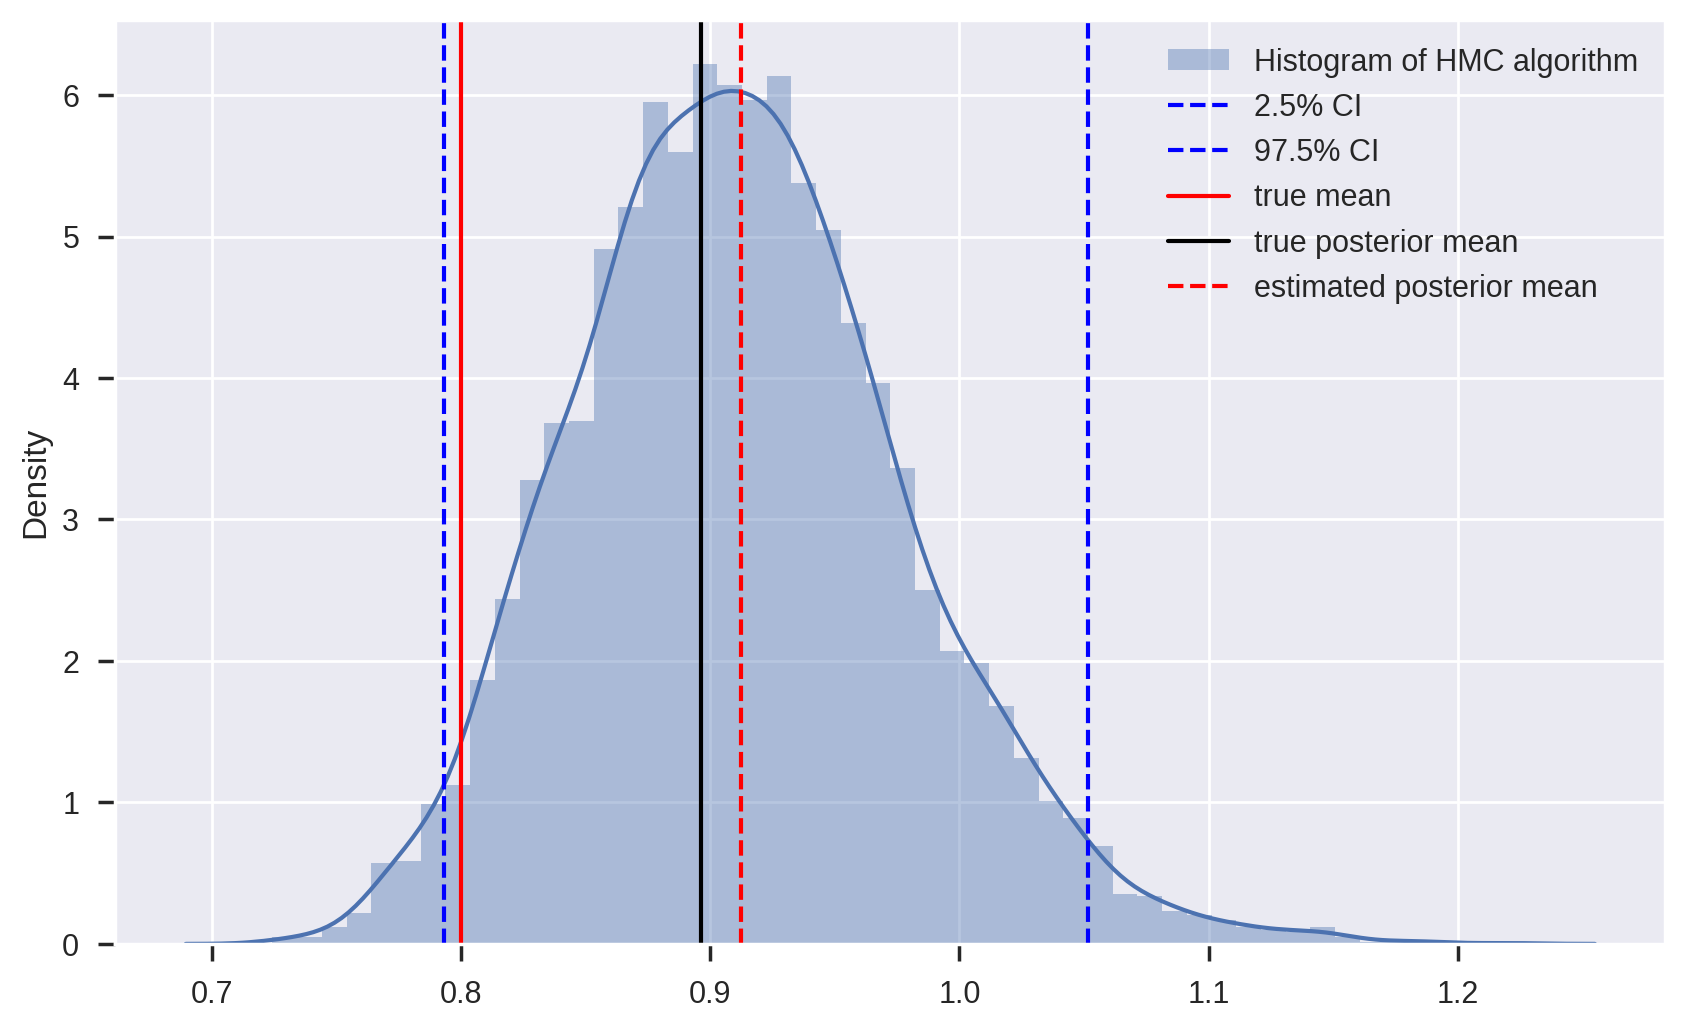

In [12]:

# batch, num_chain, signal_dim, signal_dim

# use the first chain for plotting auto-correlation,
inspect_cov = 0

sm.graphics.tsa.plot_acf(mh_states[:, 0, inspect_cov, inspect_cov],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states[:, 0, inspect_cov, inspect_cov],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)


# plot the fist chain

mh_dist = mh_states[:, 0, inspect_cov, inspect_cov]
hmc_dist = hmc_states[:, 0, inspect_cov, inspect_cov]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     mh_dist,
#     np.abs(np.random.randn(mh_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std[inspect_cov, inspect_cov], color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_std[inspect_cov, inspect_cov], color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     hmc_dist,
#     np.abs(np.random.randn(hmc_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std[inspect_cov, inspect_cov], color='red', linestyle='-', label='true mean')
ax.axvline(x=true_posterior_std[inspect_cov, inspect_cov], color='black', linestyle='-', label='true posterior mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()

## Estimation of unknown $\Sigma$ and $\mu$

Now the problem comes to estimate the joint distribution of $\Sigma$ and $\mu$. We transfer the problem to estimate the precision matrix $Λ$ and $μ$, as stated above.

We define the prior distribution of $Λ$ as the Wishart distribution.  That is, $\pi(\Lambda) \sim \mathcal{W}(\mathbf{\nu}_0, \Psi_0)$. And define $\pi(\mu) \sim \mathcal{N}(\mu_0, \Sigma_0^2)$.

Data likelihood function $l(x|\mu, \Lambda) = \prod_{i=1} \mathcal{N}(x_i| \mu, \Lambda^{-1})$.

The posterior distribution $p(\Lambda, \mu|x) ∝ \pi(\Lambda) \pi(\mu) l(x|\mu, \Lambda)$ is a Normal-Wishart distribution.

In [13]:
init_state_precision = tf.linalg.diag(tf.random.uniform([N_CHAINS, signal_dim]))
init_state_mean = tf.random.normal([N_CHAINS, signal_dim])

"""
In this case, the mean and lambda are estimated separately, they are stored in two lists
"""

"""
define prior distribution
"""
def prior_dist(Mu, Lambda):

  return tfd.JointDistributionNamed(dict(
                Mu=tfd.MultivariateNormalTriL(loc=PRIOR_MEAN,
                                  scale_tril=PRIOR_STD),
                Lambda=tfd.WishartTriL(
                              df=PRIOR_DF,
                              scale_tril=tf.linalg.cholesky(PRIOR_SCALE)))).log_prob({'Mu': Mu,
                                                                                  'Lambda': Lambda})

"""
define target distribution
"""
def posterior_dist(observations):
    def _compute_posterior(Mu, Lambda):
      precisions_cholesky = tf.linalg.cholesky(Lambda)
      covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(signal_dim, batch_shape=[N_CHAINS]))

      return tf.reduce_sum(tfd.MultivariateNormalTriL(loc=Mu,
                                                        scale_tril=tf.linalg.cholesky(covariances)).log_prob(observations), axis=0) \
                                                        + prior_dist(Mu, Lambda)

    return _compute_posterior



"""
Sampling
"""

transformed_bijector = tfb.Chain([
    # step 3: take the product of Cholesky factors
    tfb.CholeskyOuterProduct(),
    # step 2: exponentiate the diagonals
    tfb.TransformDiagonal(tfb.Exp()),
    # step 1: map a vector to a lower triangular matrix
    tfb.FillTriangular(),
])

# We dont need to transform the mean into unconstrainted space thus we just use identity map
unconstrained_to_precision = tfb.JointMap(
    bijectors=[tfb.Identity(), transformed_bijector]
)



@tf.function
def run_metropolis_hasting():
  mh_kernel = RandomWalkMetropolis(posterior_dist(replicate_observations),
                                    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1))

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=[init_state_mean, init_state_precision], #constant start, we use sigma as matrix here
                                        num_burnin_steps=num_burn_in_steps,
                                        num_steps_between_results=5,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(mh_kernel,
                                                                                    bijector=unconstrained_to_precision),
                                        seed=seed)
  return states, kernels_results

@tf.function
def run_hmc():
  hmc_kernel = HamiltonianMonteCarlo(posterior_dist(replicate_observations),
                                    step_size=0.03,
                                    num_leapfrog_steps=3)

  states, kernels_results = sample_chain(num_results=num_mcmc_samples,
                                        current_state=[init_state_mean, init_state_precision],
                                        num_burnin_steps=num_burn_in_steps,
                                        kernel=tfp.mcmc.TransformedTransitionKernel(hmc_kernel,
                                                                                    bijector=unconstrained_to_precision),
                                        seed=seed)

  return states, kernels_results

mh_states, mh_results = run_metropolis_hasting()
hmc_states, hmc_results = run_hmc()

mh_states_mean = mh_states[0]
mh_states_precision = mh_states[1]
hmc_states_mean = hmc_states[0]
hmc_states_precision = hmc_states[1]



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [14]:
#@title Diagonics For Mean { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states_mean,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states_mean,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

accept_rate_mh = tf.math.count_nonzero(mh_results.inner_results.is_accepted, axis=0)/num_mcmc_samples
accept_rate_hmc = tf.math.count_nonzero(hmc_results.inner_results.is_accepted, axis=0)/num_mcmc_samples

print(f"Acceptance rate for MH algorithm {accept_rate_mh}")
print(f"Acceptance rate for HMC algorithm {accept_rate_hmc}")

ess_mh = tfp.mcmc.effective_sample_size(
    mh_states_mean,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states_mean,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")



R^hat for MH algorithm [1.0054166 1.0060471 1.011265 ]
R^hat for HMC algorithm [1.0017941 1.0013573 1.0031552]
Acceptance rate for MH algorithm [0.0465     0.0565     0.047      0.04833333 0.0475     0.04833333
 0.05633333 0.052     ]
Acceptance rate for HMC algorithm [0.93633333 0.93866667 0.93583333 0.9435     0.93533333 0.9325
 0.93983333 0.93583333]
Effective sample size for MH algorithm [[266.6563   324.98398  158.30879 ]
 [352.66818  380.3757   172.99287 ]
 [259.45822  268.60205  192.27014 ]
 [250.60345  307.73856  125.229485]
 [215.7776   330.33676  154.43542 ]
 [256.4033   265.0154   161.2488  ]
 [341.2412   371.0979   187.90178 ]
 [286.7634   296.1117   113.57753 ]]
Effective sample size for HMC algorithm [[ 980.2812  1123.7192   479.74536]
 [1146.3914  1274.8654   350.4055 ]
 [ 992.63794 1120.7688   432.77557]
 [1018.2574  1145.3973   425.74423]
 [1191.3142  1299.61     540.8267 ]
 [1161.7229  1304.1184   457.87848]
 [1091.707   1283.4785   461.9214 ]
 [1157.3158  1202.6931  

In [15]:
#@title Diagonics For Covariance { display-mode: "form" }

r_hat_mh = tfp.mcmc.potential_scale_reduction(
    mh_states_precision,
    independent_chain_ndims=1,
    split_chains=True)
r_hat_hmc = tfp.mcmc.potential_scale_reduction(
    hmc_states_precision,
    independent_chain_ndims=1,
    split_chains=True)

print(f"R^hat for MH algorithm {r_hat_mh}")
print(f"R^hat for HMC algorithm {r_hat_hmc}")

ess_mh = tfp.mcmc.effective_sample_size(
    mh_states_precision,
    cross_chain_dims=None,
)
ess_hmc = tfp.mcmc.effective_sample_size(
    hmc_states_precision,
    cross_chain_dims=None,
)

print(f"Effective sample size for MH algorithm {ess_mh}")
print(f"Effective sample size for HMC algorithm {ess_hmc}")



R^hat for MH algorithm [[1.010968  1.0179222 1.0029806]
 [1.0179222 1.0159994 1.003298 ]
 [1.0029806 1.003298  1.0069914]]
R^hat for HMC algorithm [[1.0023161 1.0043515 1.0001242]
 [1.0043515 1.004265  1.0002908]
 [1.0001242 1.0002908 1.0005555]]


Effective sample size for MH algorithm [[[157.0895   106.283646 548.17206 ]
  [106.283646 111.30024  496.82108 ]
  [548.17206  496.82108  492.50778 ]]

 [[136.3808    84.556114 527.3294  ]
  [ 84.556114  85.777214 501.9296  ]
  [527.3294   501.9296   621.63684 ]]

 [[176.12335  105.1772   356.2107  ]
  [105.1772   109.58429  352.45618 ]
  [356.2107   352.45618  523.37134 ]]

 [[206.20656  117.40148  604.8832  ]
  [117.40148  101.89243  679.0359  ]
  [604.8832   679.0359   526.8738  ]]

 [[221.44218  135.86322  455.3349  ]
  [135.86322  139.60039  474.09363 ]
  [455.3349   474.09363  600.68695 ]]

 [[ 88.36156   59.741474 507.84976 ]
  [ 59.741474  62.95861  406.4294  ]
  [507.84976  406.4294   498.5998  ]]

 [[140.12392   84.24091  604.2013  ]
  [ 84.24091   81.62417  579.3576  ]
  [604.2013   579.3576   571.4427  ]]

 [[201.1966   131.6086   600.0566  ]
  [131.6086   141.69936  536.4503  ]
  [600.0566   536.4503   599.82104 ]]]
Effective sample size for HMC algorithm [[[ 463.2376   27

<ipython-input-16-39f3e7f8196a>:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


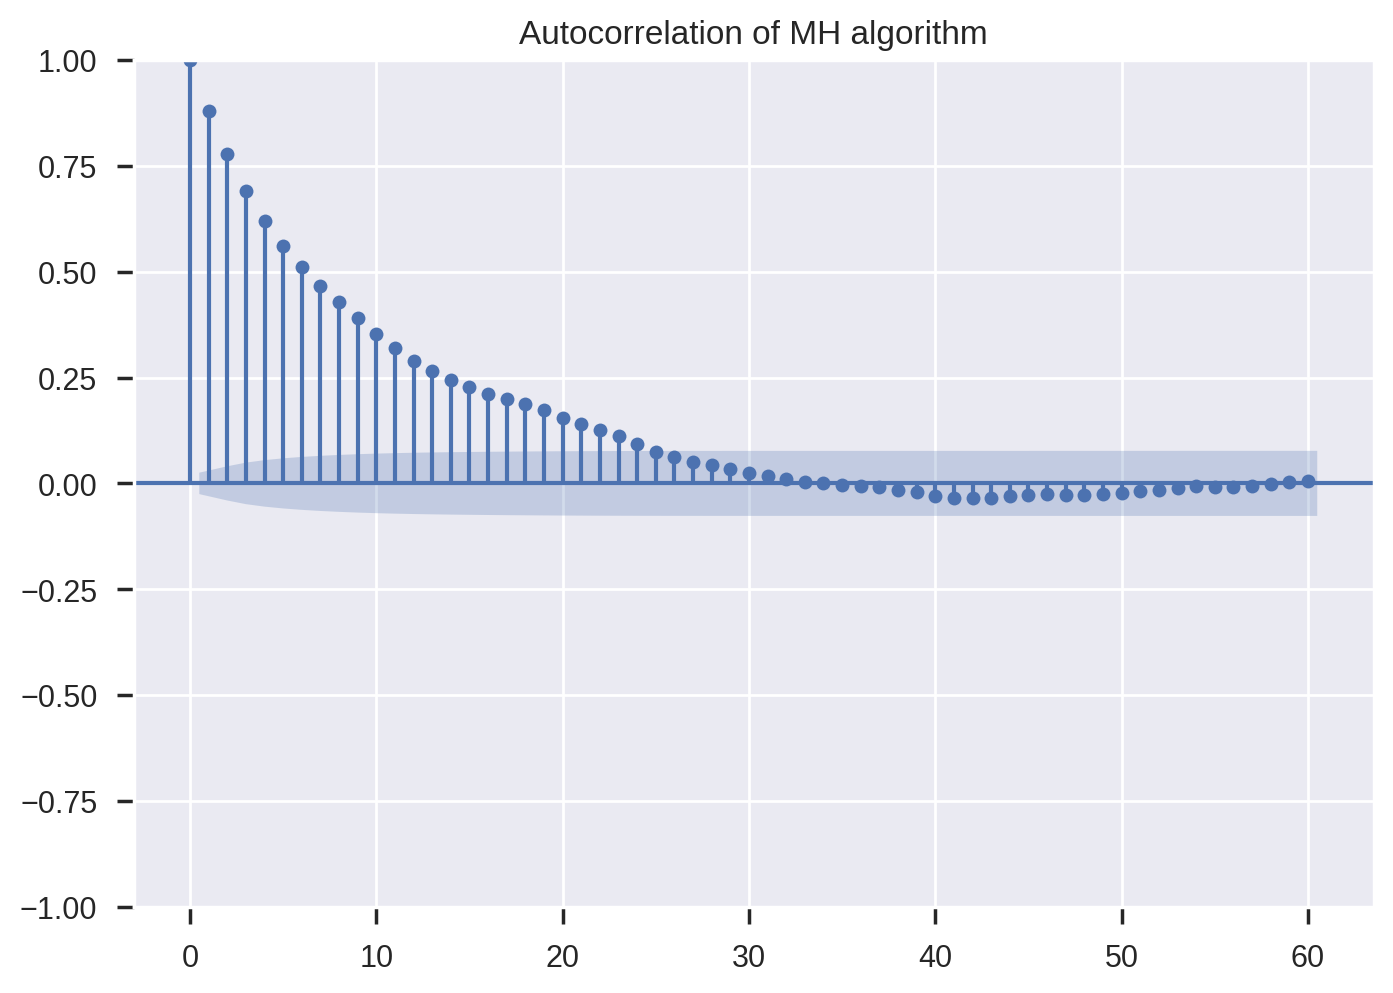

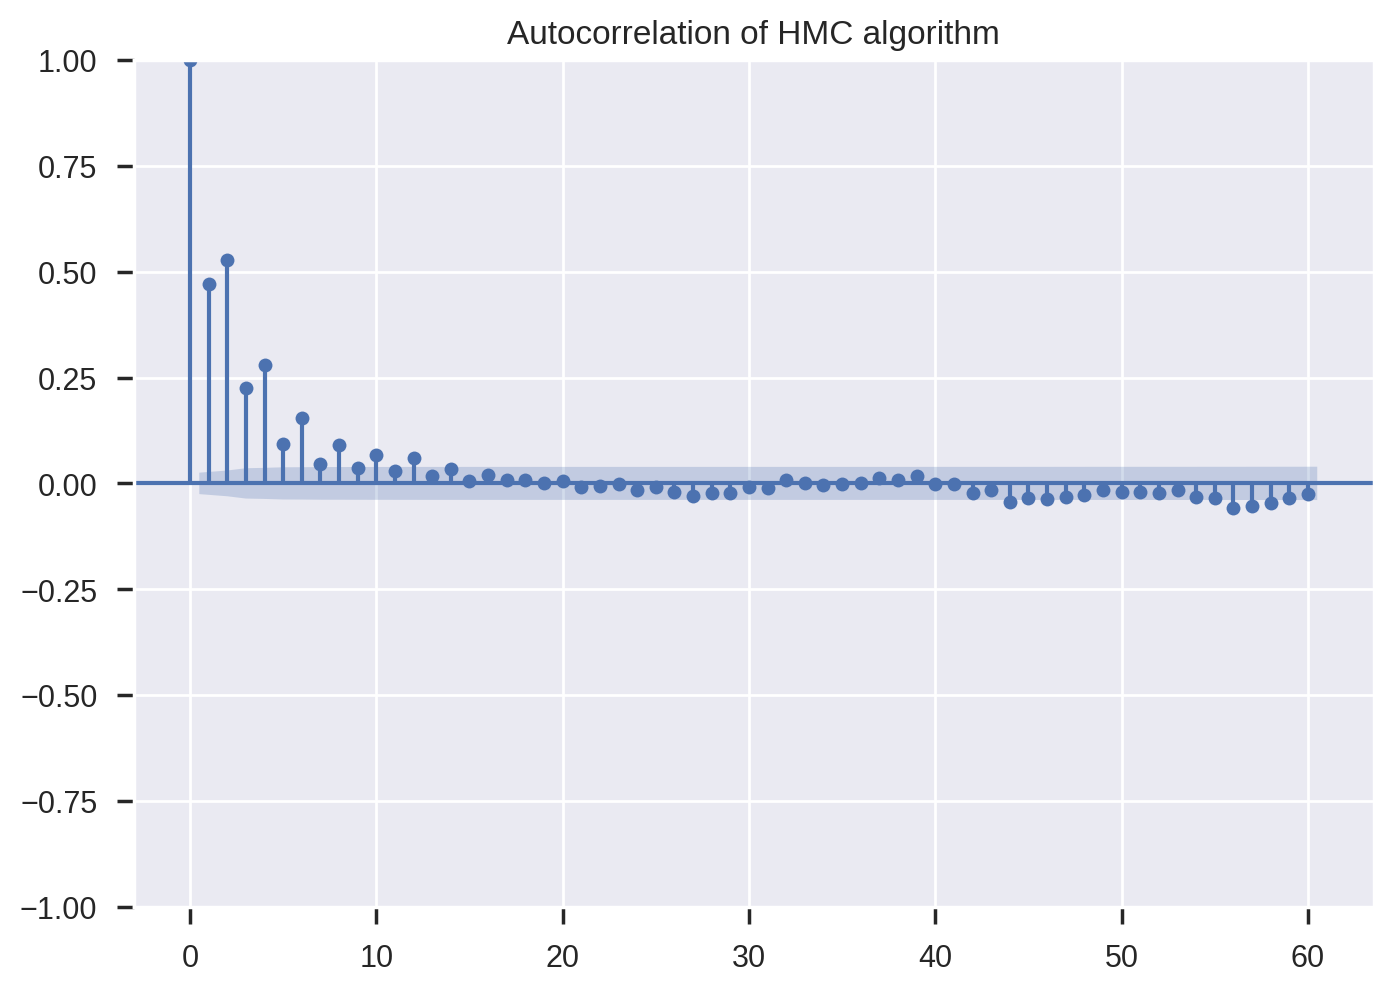

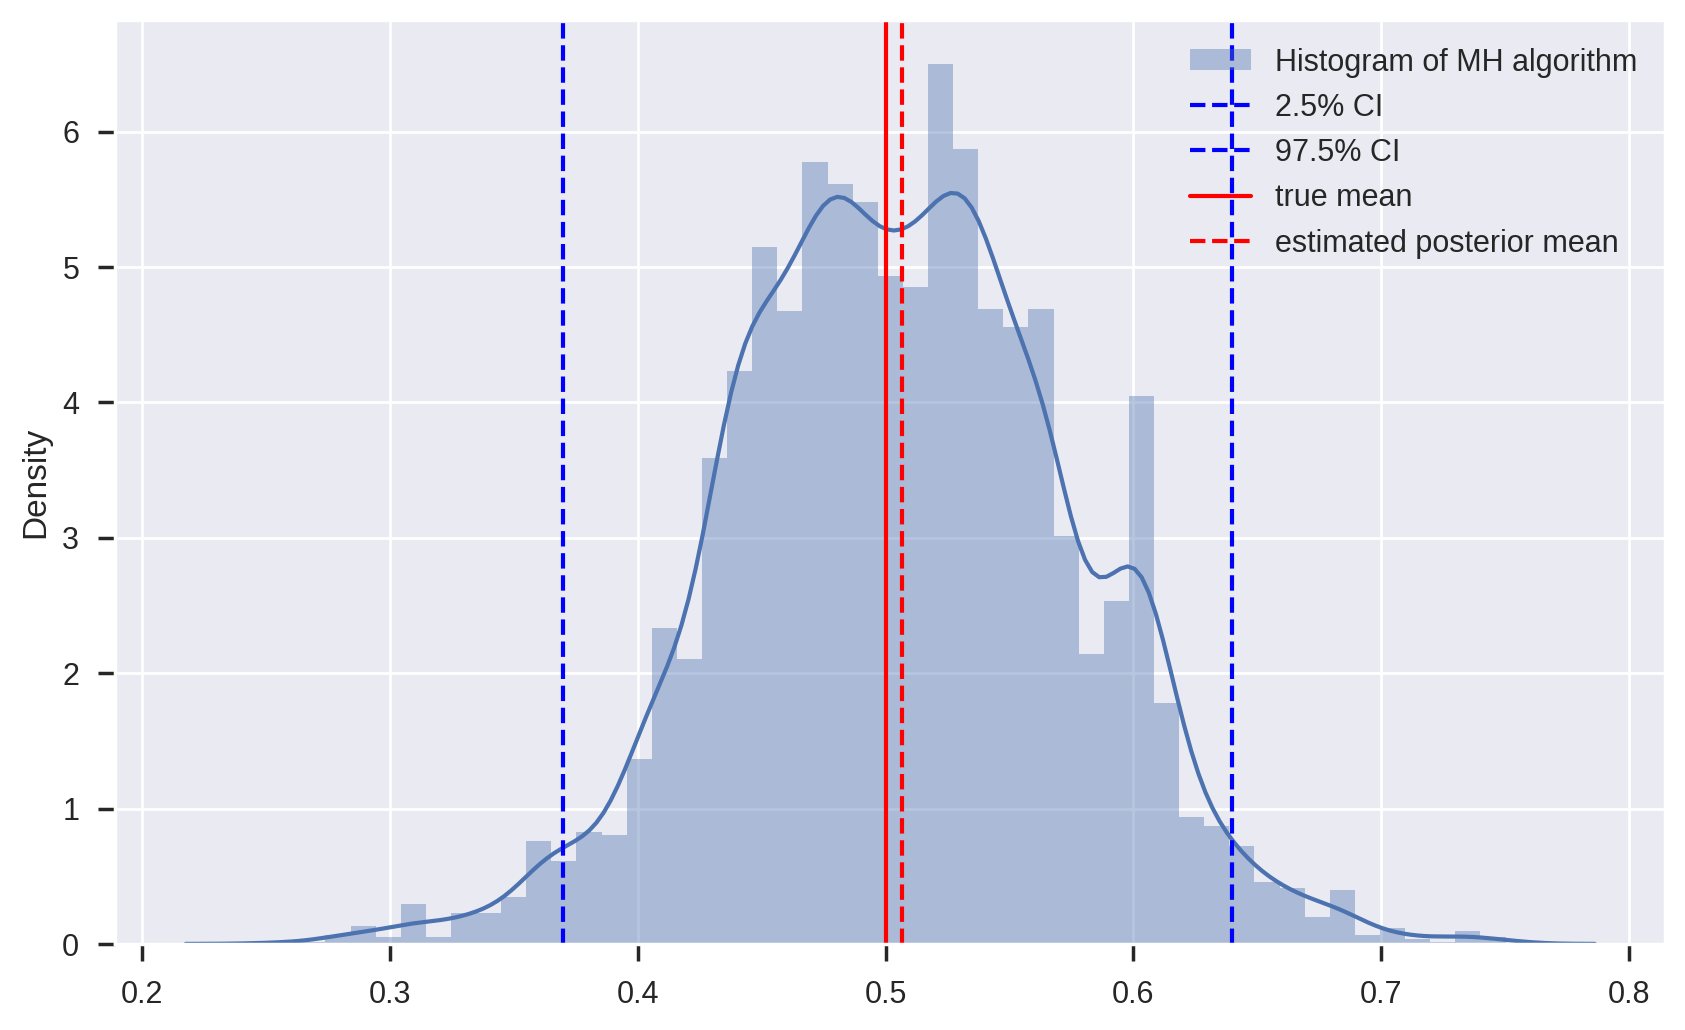

<ipython-input-16-39f3e7f8196a>:57: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


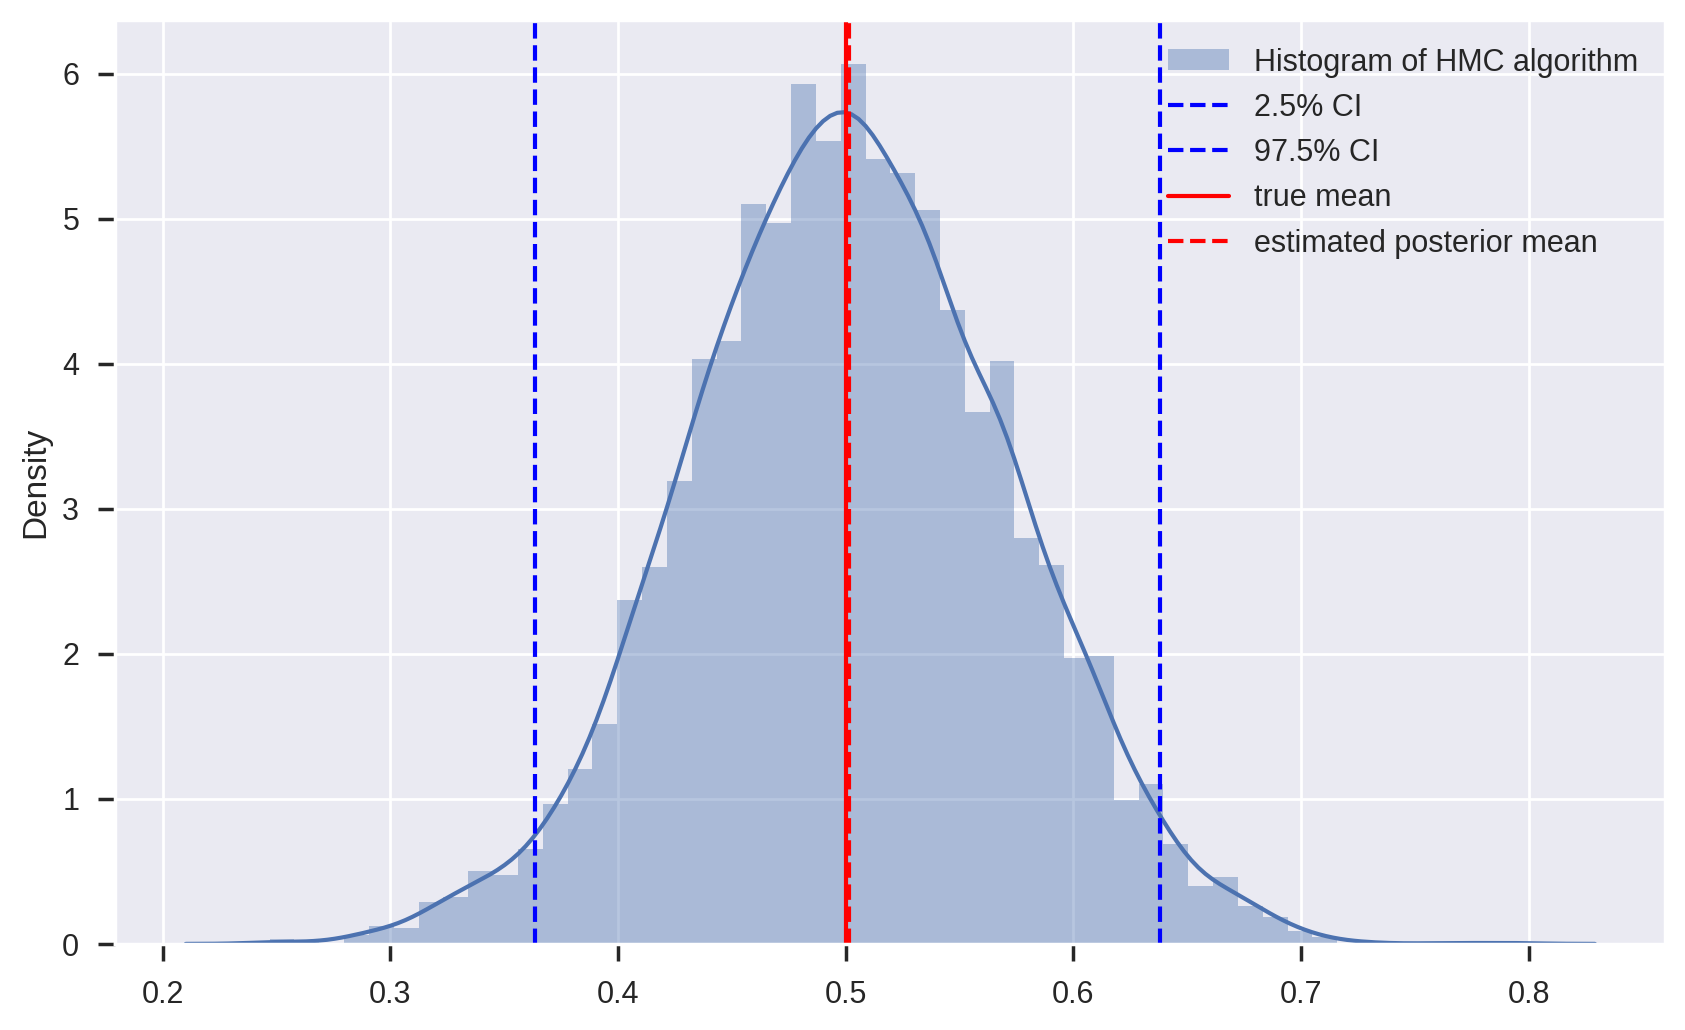

In [16]:
#@title Plot Of Mean { display-mode: "form" }


# use the first chain for plotting auto-correlation,
inspect_mean = 1

sm.graphics.tsa.plot_acf(mh_states_mean[:, 0, inspect_mean],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states_mean[:, 0, inspect_mean],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)


# plot the fist chain

mh_dist = mh_states_mean[:, 0, inspect_mean]
hmc_dist = hmc_states_mean[:, 0, inspect_mean]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     mh_dist,
#     np.abs(np.random.randn(mh_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean[inspect_mean], color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     hmc_dist,
#     np.abs(np.random.randn(hmc_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_mean[inspect_mean], color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()

<ipython-input-17-d8a1b43f4e4c>:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')


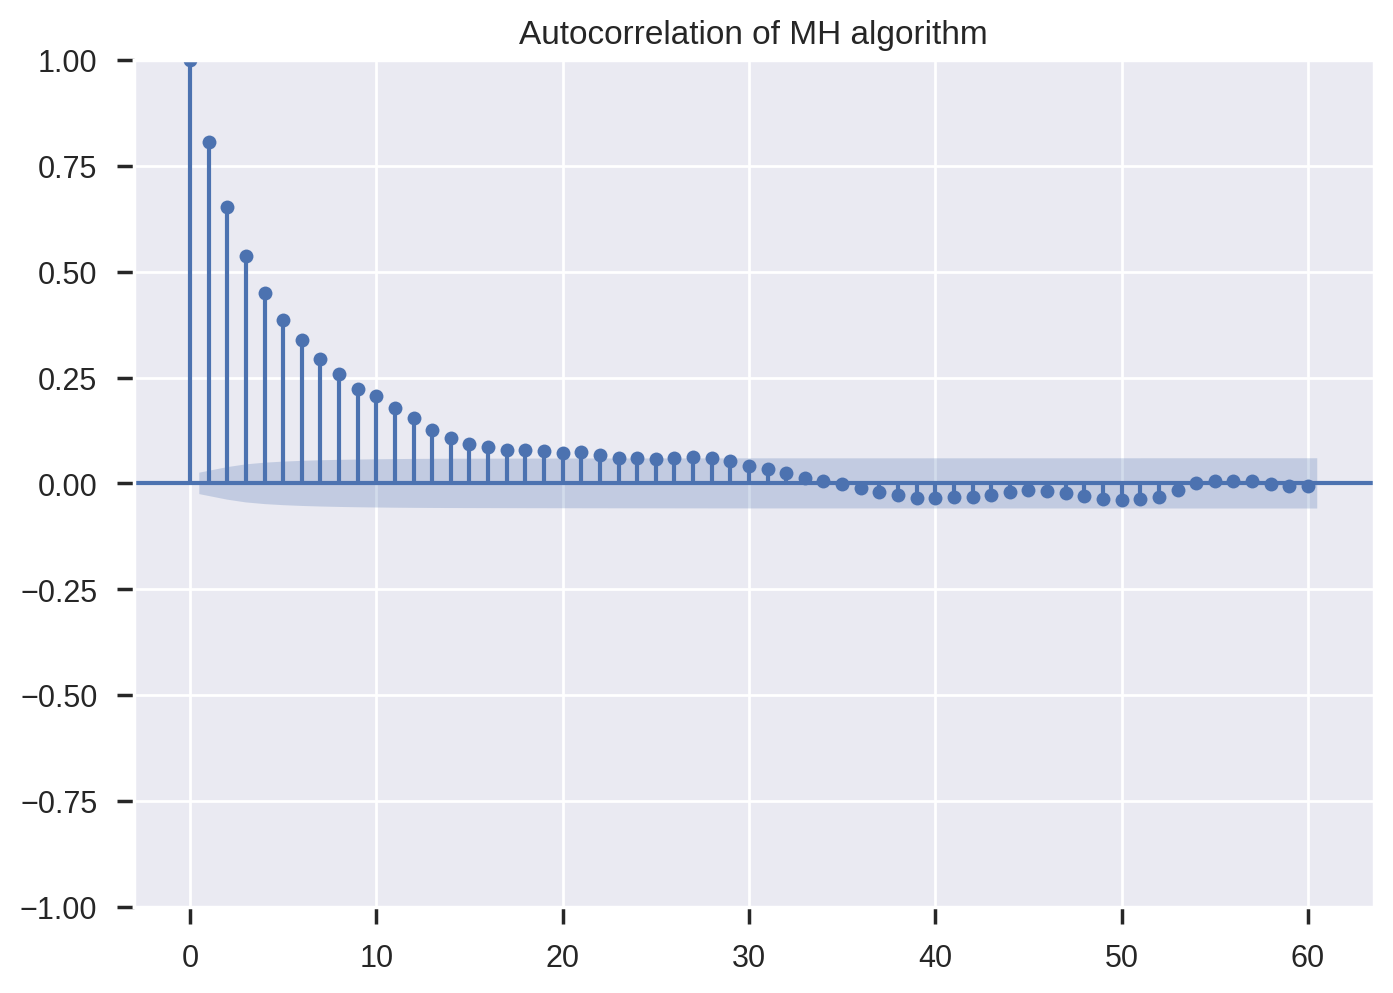

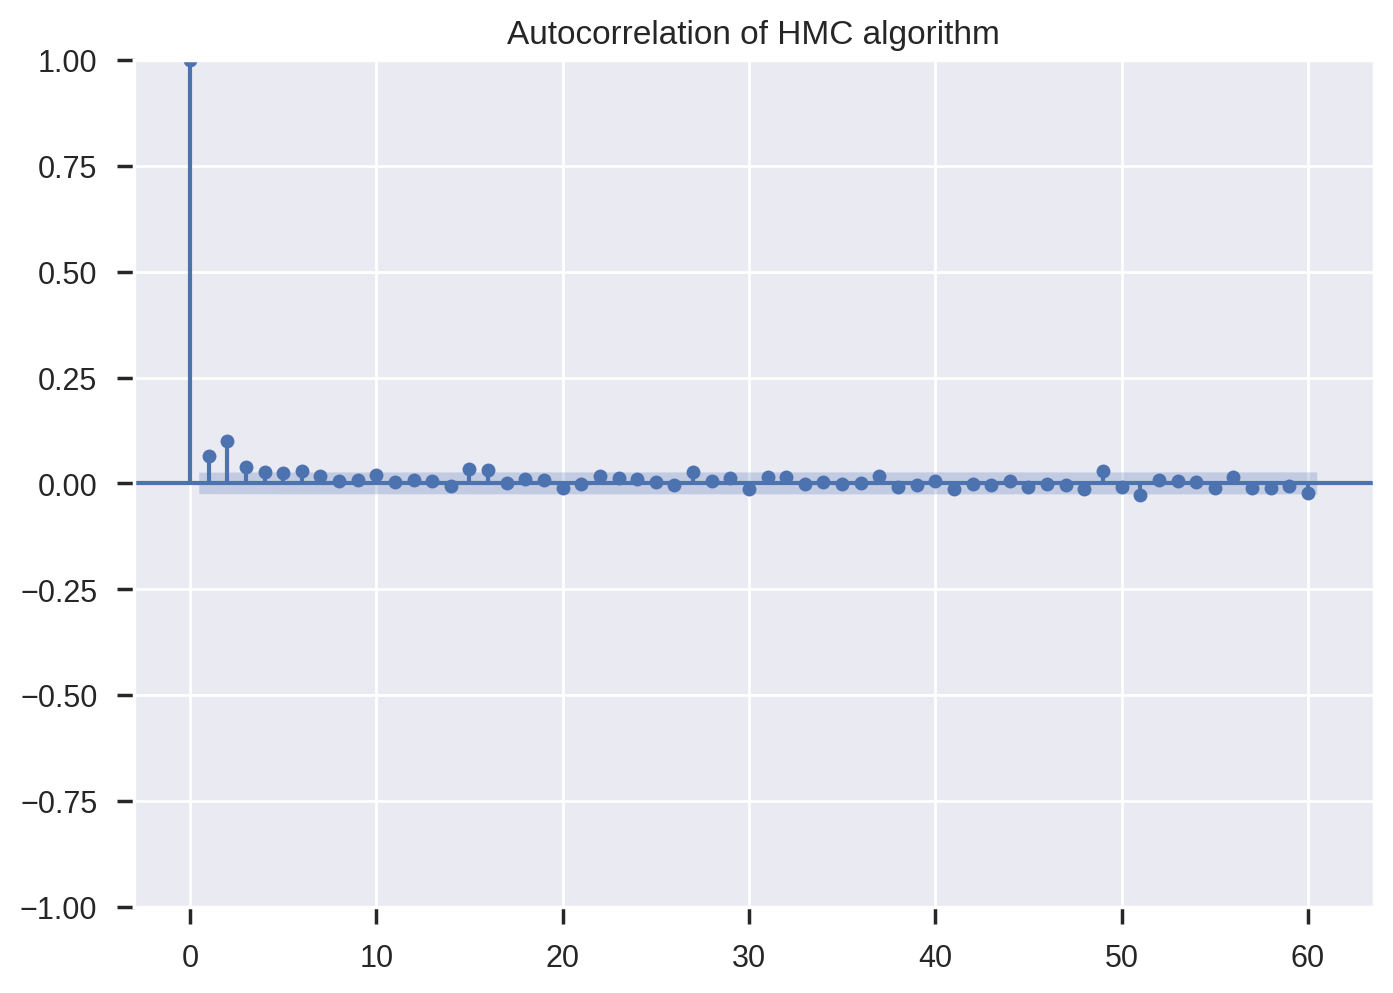

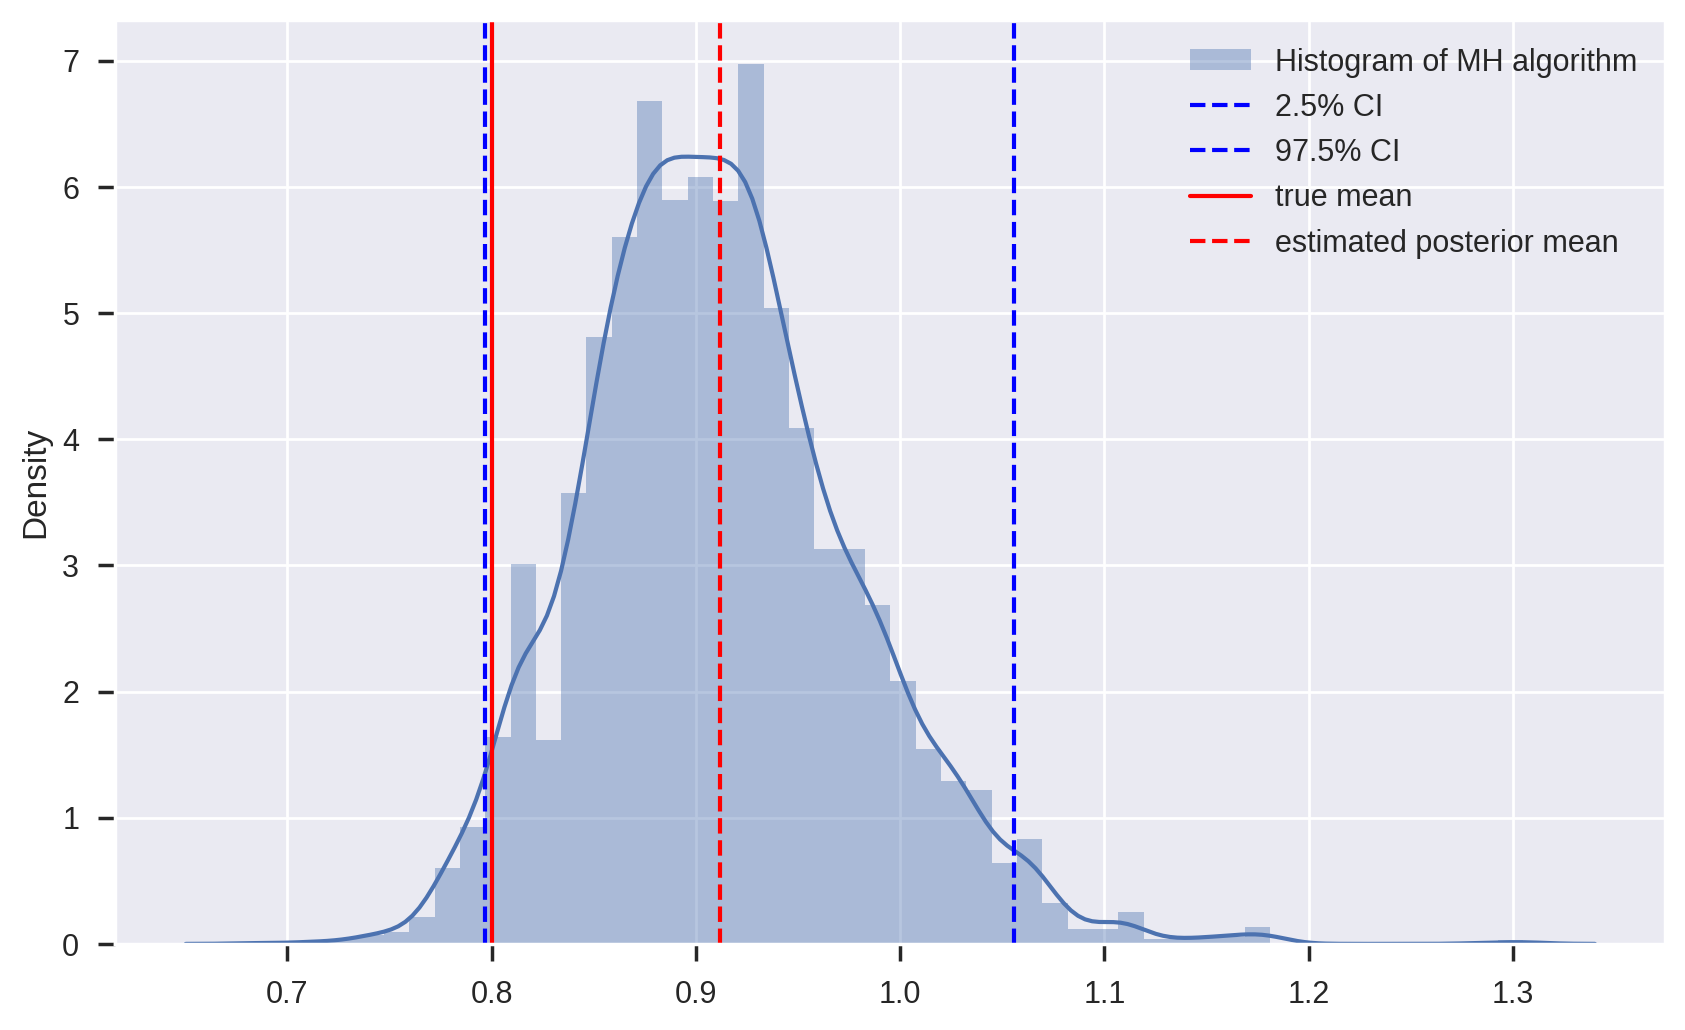

<ipython-input-17-d8a1b43f4e4c>:60: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')


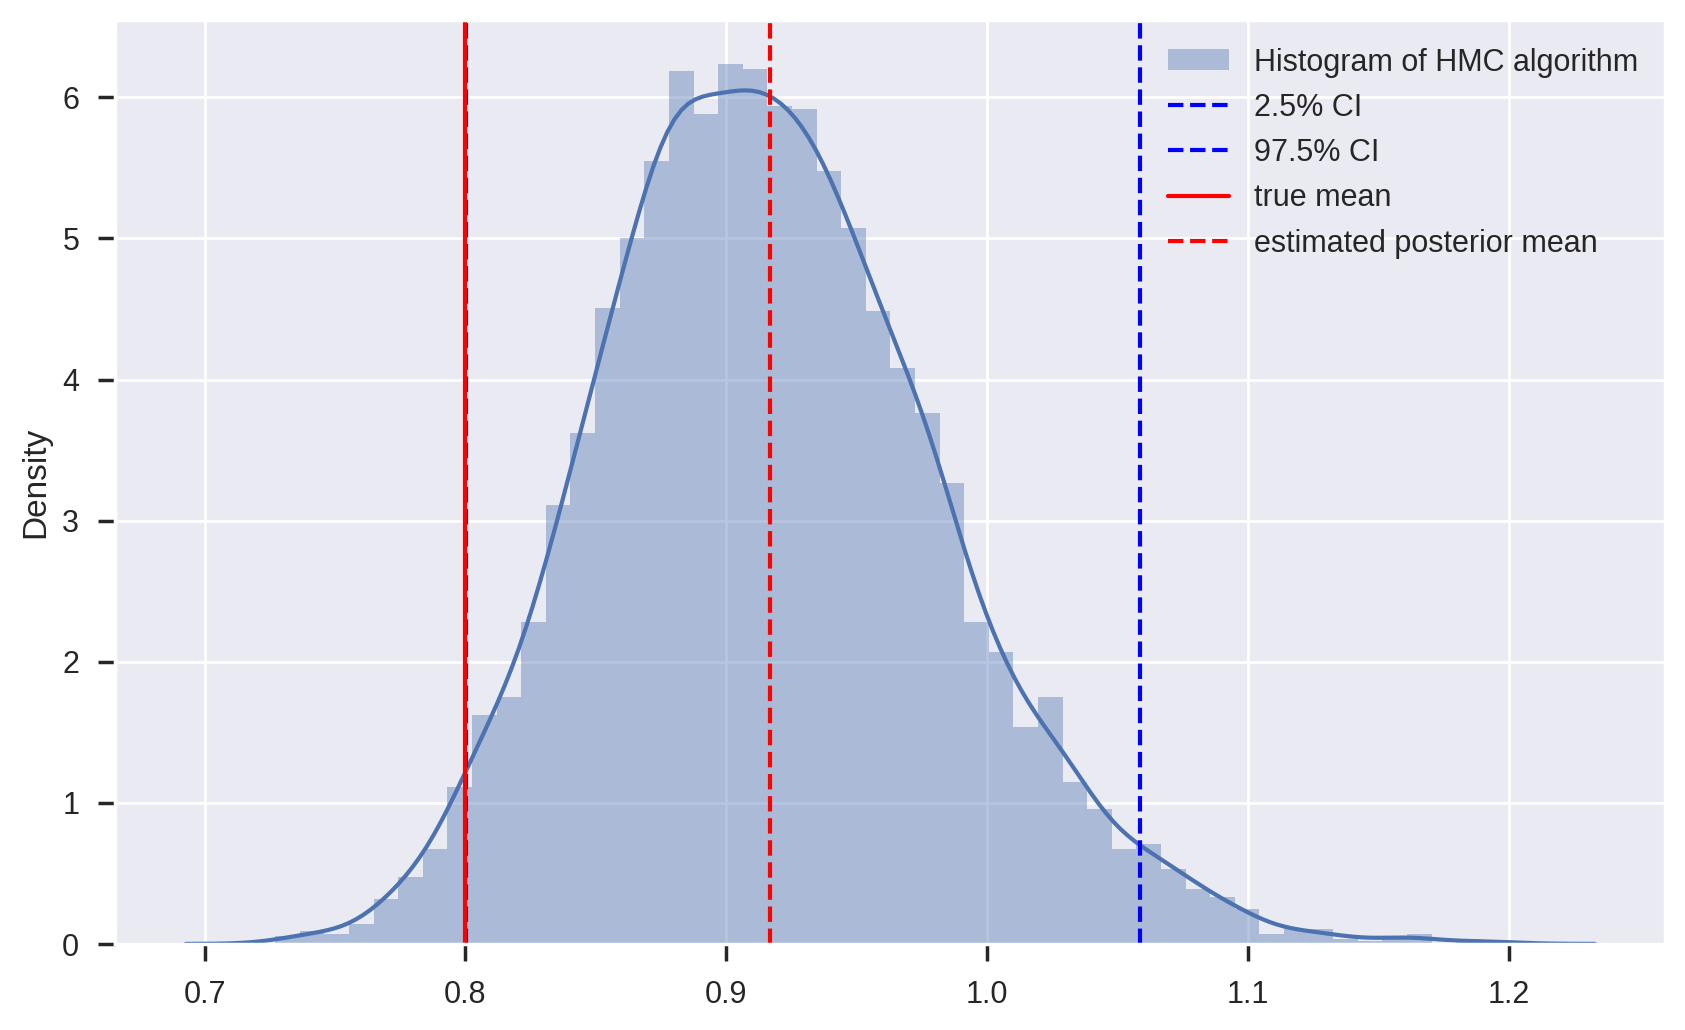

In [17]:
#@title Plot Of Covariance { display-mode: "form" }

mh_states = tf.linalg.cholesky(tf.linalg.inv(mh_states_precision))
hmc_states = tf.linalg.cholesky(tf.linalg.inv(hmc_states_precision))
# batch, num_chain, signal_dim, signal_dim

# use the first chain for plotting auto-correlation,
inspect_cov = 0

sm.graphics.tsa.plot_acf(mh_states[:, 0, inspect_cov, inspect_cov],
                         title='Autocorrelation of MH algorithm',
                         lags=60)
sm.graphics.tsa.plot_acf(hmc_states[:, 0, inspect_cov, inspect_cov],
                         title='Autocorrelation of HMC algorithm',
                         lags=60)


# plot the fist chain

mh_dist = mh_states[:, 0, inspect_cov, inspect_cov]
hmc_dist = hmc_states[:, 0, inspect_cov, inspect_cov]

# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     mh_dist,
#     np.abs(np.random.randn(mh_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(mh_dist, ax=ax, label='Histogram of MH algorithm')
# lines = ax.hist(mh_dist, bins=100, edgecolor="k", label="Histogram of MH algorithm")
ci_mh = credible_interval(mh_dist)
ax.axvline(x=ci_mh[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_mh[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std[inspect_cov, inspect_cov], color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(mh_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()


# Scatter plot of data samples and histogram
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.scatter(
#     hmc_dist,
#     np.abs(np.random.randn(hmc_dist.size)),
#     zorder=15,
#     color="red",
#     marker="x",
#     alpha=0.5,
#     label="Samples",
# )
sns.distplot(hmc_dist, ax=ax, label='Histogram of HMC algorithm')
# lines = ax.hist(hmc_dist, bins=100, edgecolor="k", label="Histogram of HMC algorithm")
ci_hmc = credible_interval(hmc_dist)
ax.axvline(x=ci_hmc[0], color='blue', linestyle='--', label='2.5% CI')
ax.axvline(x=ci_hmc[1], color='blue', linestyle='--', label='97.5% CI')
ax.axvline(x=true_std[inspect_cov, inspect_cov], color='red', linestyle='-', label='true mean')
ax.axvline(x=np.mean(hmc_dist), color='red', linestyle='--', label='estimated posterior mean')

ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.show()